Исходные данные

base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

target.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

validation_answer.csv - правильные ответы к предыдущему файлу.


Задача:

разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;

оценить качество алгоритма по метрике accuracy@5

*деплой: разработать REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.


# Импорты и загрузки

## Импорты

In [3]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 28.5 MB/s eta 0:00:00


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss

import zipfile
import requests
import os
import time


from scipy.spatial.distance import pdist, squareform
from tqdm.notebook import tqdm
from urllib.parse import urlencode
from datetime import datetime
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV #train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


In [ ]:
#pd.set_option('display.max_columns', None)


## Загрузка данных из yandex.drive на виртуальный диск Colab

mini версия согласована с @DinEqu т.к. ни мой ноутбук, ни colab падали с ошибкой переполнения памяти на шаге с ml (~11 gb из 12 уже было использовано)
Для заказчика делал бы предсказания на 20 предсказаний faiss для каждого товара. но чтобы пройти по памяти. уменьшил до 5. Извините, что такая укороченная версия. Тут гораздо важнее ход мысли, чем замена 5 на 20. Подготовку даеных и выводы изначально делал на большом df -> выводы остались от него. Ч вашего разрешения переписывать не стал, т.к. большой df более информативен/ Впереди вас ждет вопросы по улучшению работы. Спасибо за будущие ответы)

In [5]:

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
#public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'
public_key = 'https://disk.yandex.ru/d/ms8ZxvsLhwFkwA'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
#with open('data.zip', 'wb') as f:   # Здесь укажите нужный путь к файлу
#    f.write(download_response.content)

with open('yp-match-mini.zip', 'wb') as f:   # Здесь укажите нужный путь к файлу
    f.write(download_response.content)

# Укажите путь к zip-архиву
#zip_path = '/content/data.zip'
zip_path = '/content/yp-match-mini.zip'

# Распаковка zip-архива
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

Сохранение файлов в csv

In [61]:
train = pd.read_csv('train_mini.csv')
validation = pd.read_csv('validation_mini.csv' )
validation_answer = pd.read_csv('validation_answer_mini.csv' )
base = pd.read_csv('base_mini.csv')

# выделение целевого признака из обучающей выборки. Значения + название столбца
train_targets = train.pop('Target').to_frame()

##Первичный анализ данных

Функция для первичного анали данных

In [7]:
def exploratory(data):
    """
    Функция для
        описания размера датафрейма
        количество дублирующих записей и пропусков
        и диаграмма рассеивания признаков
    """
    print(f"Размер:    {data.shape}")
    display("Первые 5 строк         ", data.head())
    print(f"Типы полей:")
    print(data.info())
    print(f"Описательная статистика:")
    print(data.describe())
    print("Пропущенные значения, %:         ", data.isna().sum()/len(data.index)* 100)
    print("Дубли построчно:   ", data.duplicated().sum())
    print("Гистограмма распределения:")
    data.hist(figsize=[20, 20], bins=50)

Первичный анализ train

Размер:    (20000, 73)


'Первые 5 строк         '

Id          0          1          2          3          4  \
0   1-query  -87.77637   6.806268 -32.054546 -177.26039  120.80333   
1  14-query -107.74551   8.262278   1.303707 -122.30960  124.88633   
2  17-query  -64.54115   6.379174  22.827354 -140.19008  118.12147   
3  21-query  -41.34329  12.988533 -52.500470 -177.08405  117.42550   
4  24-query -133.16289  -2.366189 -24.341312 -163.20690  136.80786   

            5          6           7          8  ...         62         63  \
0  -83.810590  -94.57275  -78.433090  124.91590  ... -40.812233   4.669178   
1 -113.067260 -759.62604  -50.134230  125.86170  ... -77.386720  19.192116   
2  -45.949470 -167.82553   76.232230  116.56160  ... -99.924270  68.939440   
3  -64.219170 -759.62604  119.854680  116.59877  ... -48.169018  33.574203   
4  -64.591225 -759.62604    0.566725  121.06721  ... -66.291520  21.065586   

          64          65         66         67         68          69  \
0 -151.69771   -1.638704  68.170876  25.096191  89.974976  130.589630   
1 -169.01462  129.329820  69.071840 -21.853165  91.174060   86.220680   
2 -232.42427 -151.365800  66.982070  21.464298  31.847046  125.621956   
3 -140.07430  -74.130066  70.309480  22.298388  53.082397  113.545525   
4 -151.60904   21.146963  71.008780 -37.431760  57.041412  141.719480   

           70          71  
0 -1035.09220  -51.276833  
1  -951.97925 -119.347946  
2 -1179.73110  -48.768707  
3  -653.41100    8.083492  
4 -1181.58060  -36.334442  

[5 rows x 73 columns]

Типы полей:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      20000 non-null  object 
 1   0       20000 non-null  float64
 2   1       20000 non-null  float64
 3   2       20000 non-null  float64
 4   3       20000 non-null  float64
 5   4       20000 non-null  float64
 6   5       20000 non-null  float64
 7   6       20000 non-null  float64
 8   7       20000 non-null  float64
 9   8       20000 non-null  float64
 10  9       20000 non-null  float64
 11  10      20000 non-null  float64
 12  11      20000 non-null  float64
 13  12      20000 non-null  float64
 14  13      20000 non-null  float64
 15  14      20000 non-null  float64
 16  15      20000 non-null  float64
 17  16      20000 non-null  float64
 18  17      20000 non-null  float64
 19  18      20000 non-null  float64
 20  19      20000 non-null  float64
 21  20      20000 non-null 

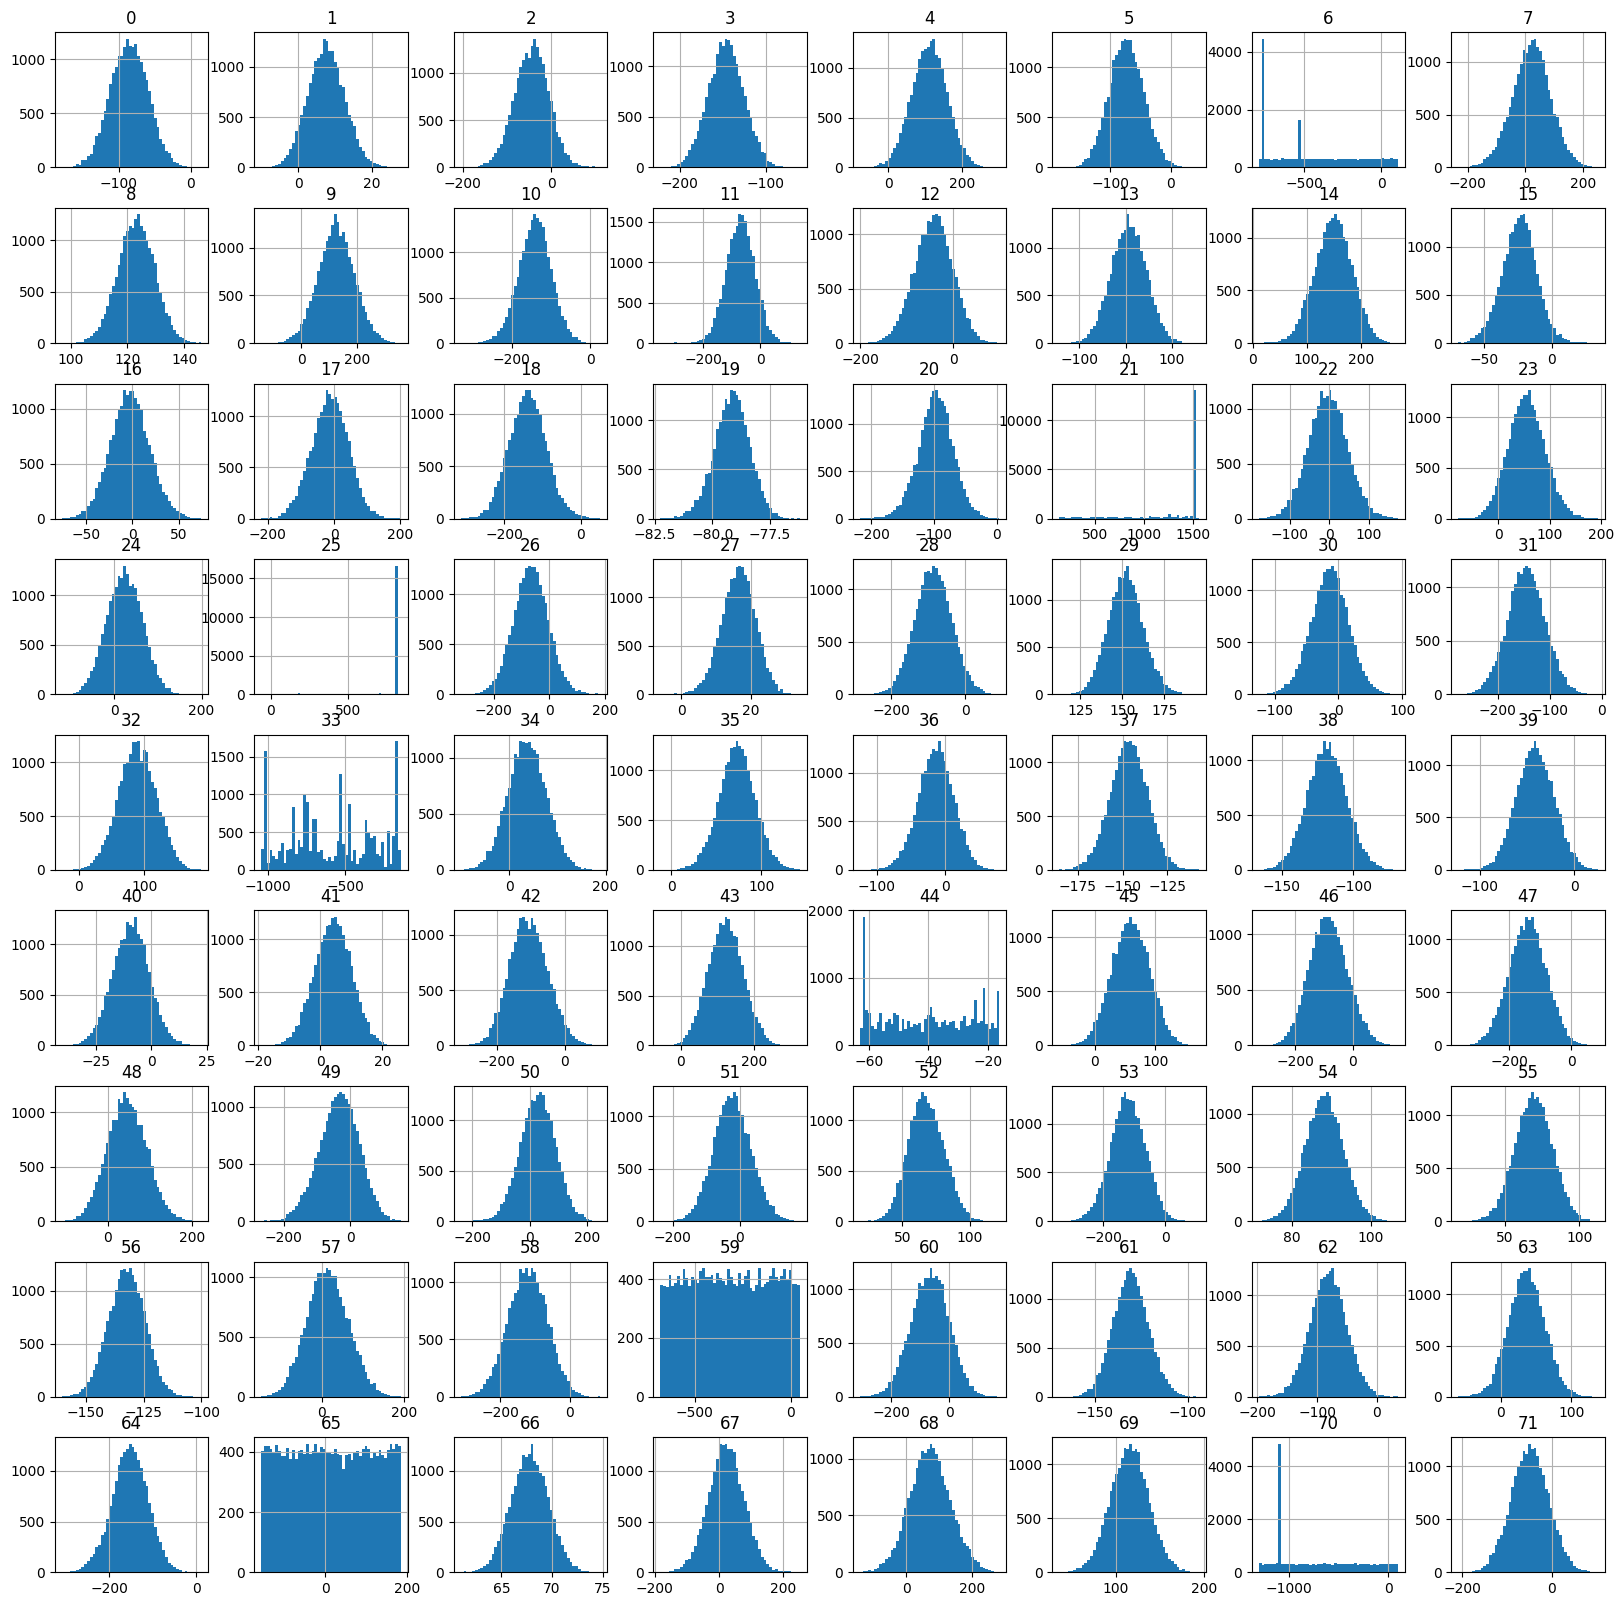

In [8]:
exploratory(train)

в большинстве столюцов распределение, близкое к нормальному.

 столбцы '6', '21', '25', '33', '44', '59', '65', '70' по другому распределены.
Рассмотрим их отдельно

**Вопрос ревьюеру**
Графики ниже - не информативны. Возможно можете подсказать, как еще можно визуализиоравать для поиска закономерностей на графике.
Из данных видно, что на одно значений приходится до 80% всех значений в столбце
Обычно строил диаграмму рассеивания и ящик с усами (код переиспользую из проекта в проект и обычно выводя все значения, визуально все становилось гораздо понятнеее, потому что значений было немного, до 50).
Здесь у нас есть столбцы ['6', '21', '25', '33', '44', '59', '65', '70'] без нормального распределения. Из-за большого количества значений почти на всех графиках распределение не информативно. Ситуация сохраняется, даже если оставить верхние 10%.

Возможно ответ будет в другой области. Вы какими библиотеками для первичного анализа данных пользуетесь? Чтобы не от руки перекопировать и видоизменять код, а в пару строчек получить больше информативных срезов.

In [9]:
#Функция для анализа распредедния и выбросов
def plot_distribution_and_boxplot(data, selected_columns):
  for column in selected_columns:
    # Создание фигуры с двумя подграфиками
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

    #n = int(len(train[column]) * 0.05)
    top_values = data[column].nlargest(5000)

    print(f"Для столбца {column}:")
    # График распределения
    axes[0].scatter(top_values.index, top_values, color='skyblue', alpha=0.7)
    #axes[0].hist(train[column], bins=90, density=True, alpha=0.7, color='skyblue')
    axes[0].set_title('График распределения')
    axes[0].set_xlabel('Значения')
    axes[0].set_ylabel('Частота')
    axes[0].grid(axis='y', alpha=0.75)

    # Ящик с усами
    axes[1].boxplot(top_values, vert=False)
    axes[1].set_title('Ящик с усами')
    axes[1].set_xlabel('Значения')

    plt.show()

Для столбца 6:


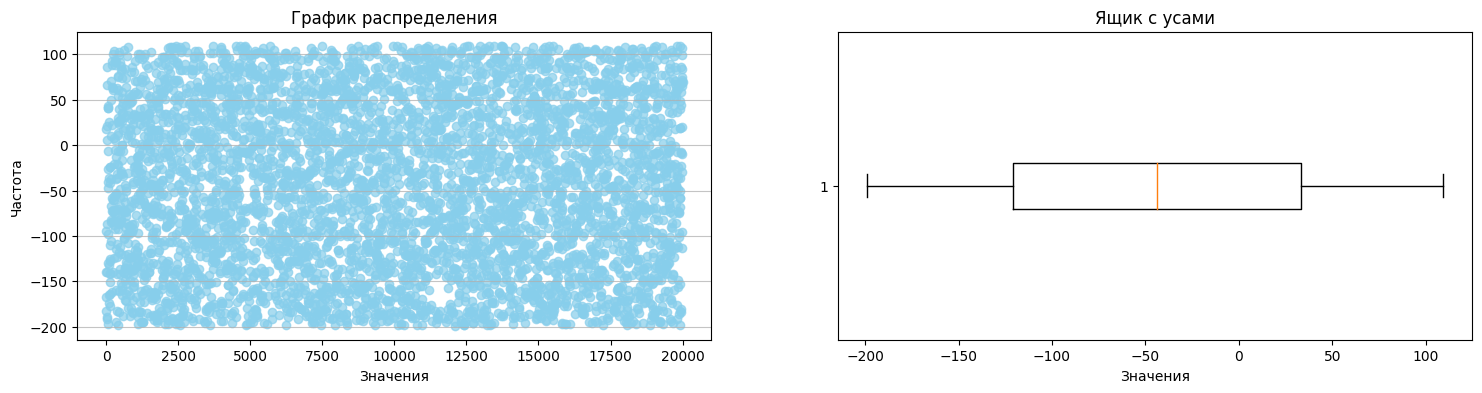

Для столбца 21:


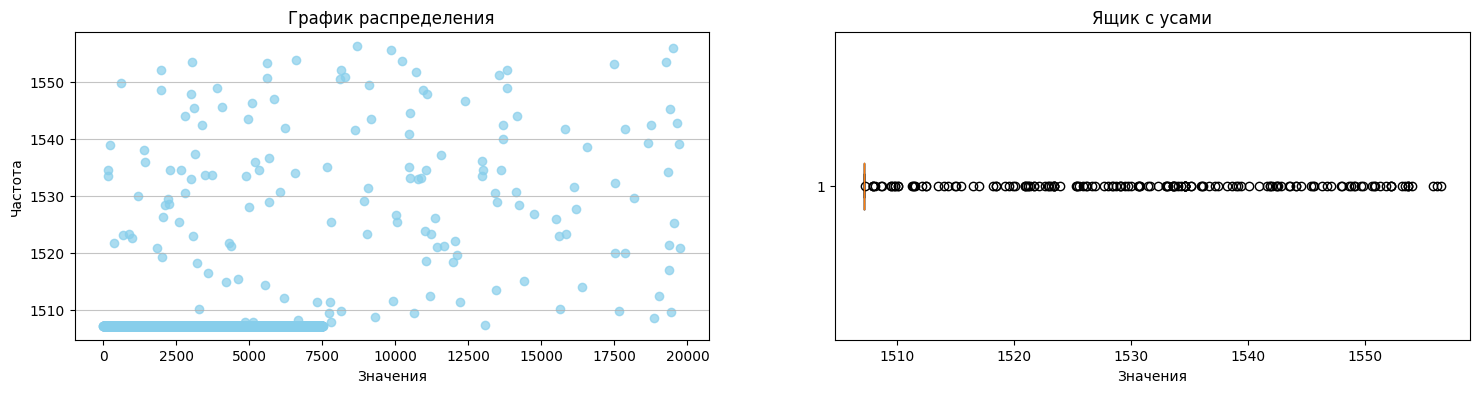

Для столбца 25:


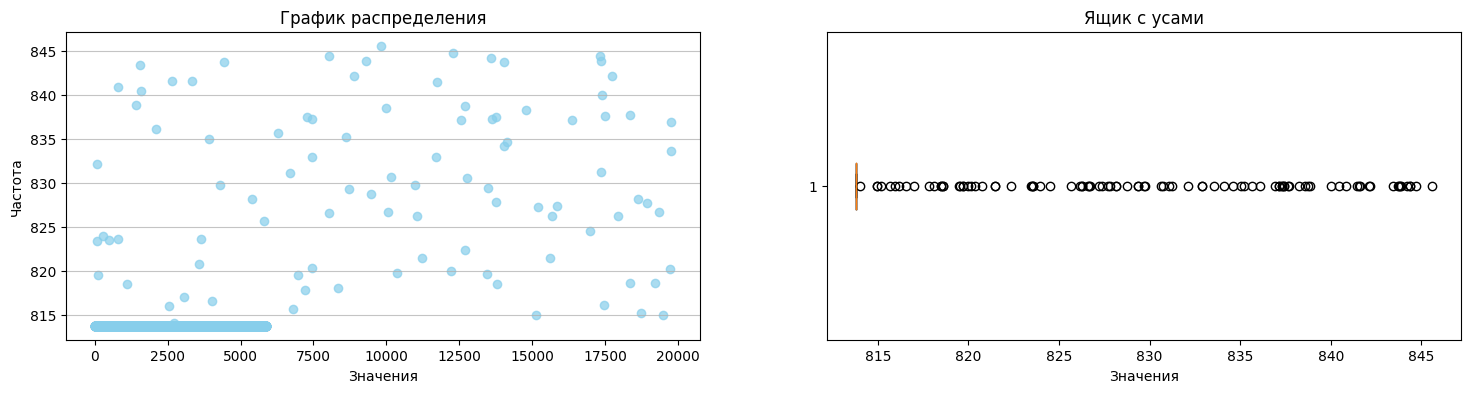

Для столбца 33:


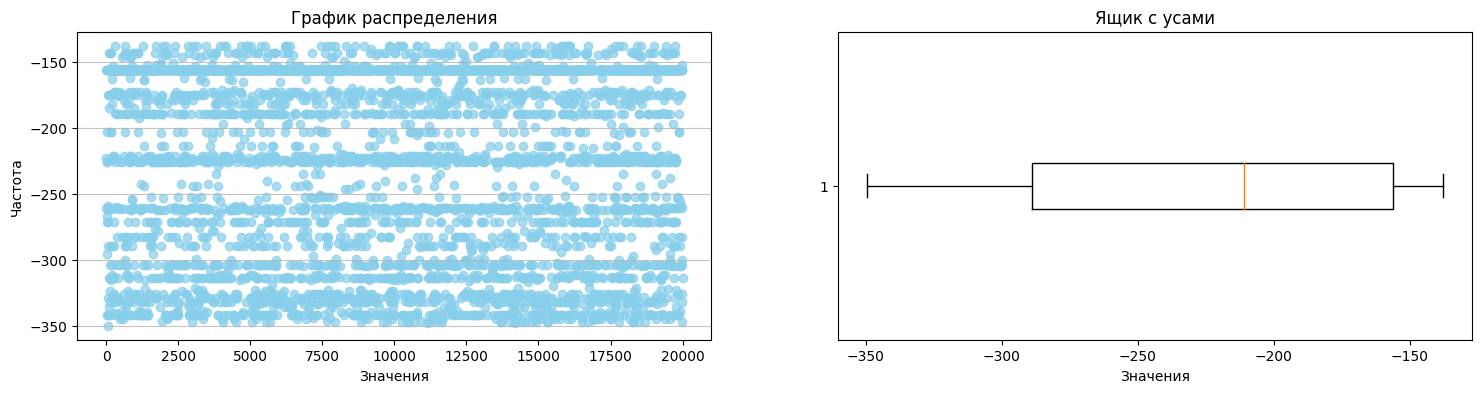

Для столбца 44:


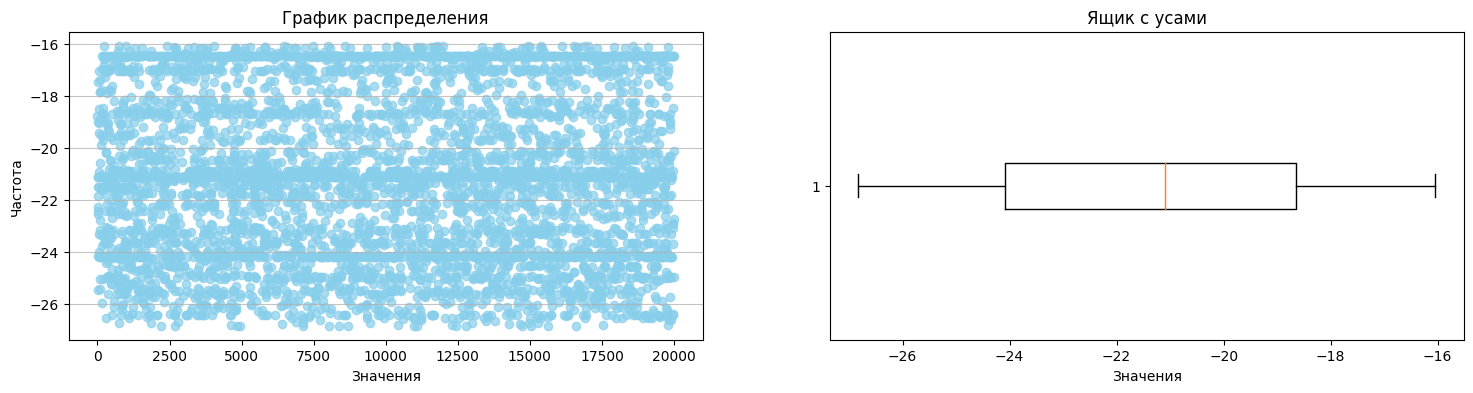

Для столбца 59:


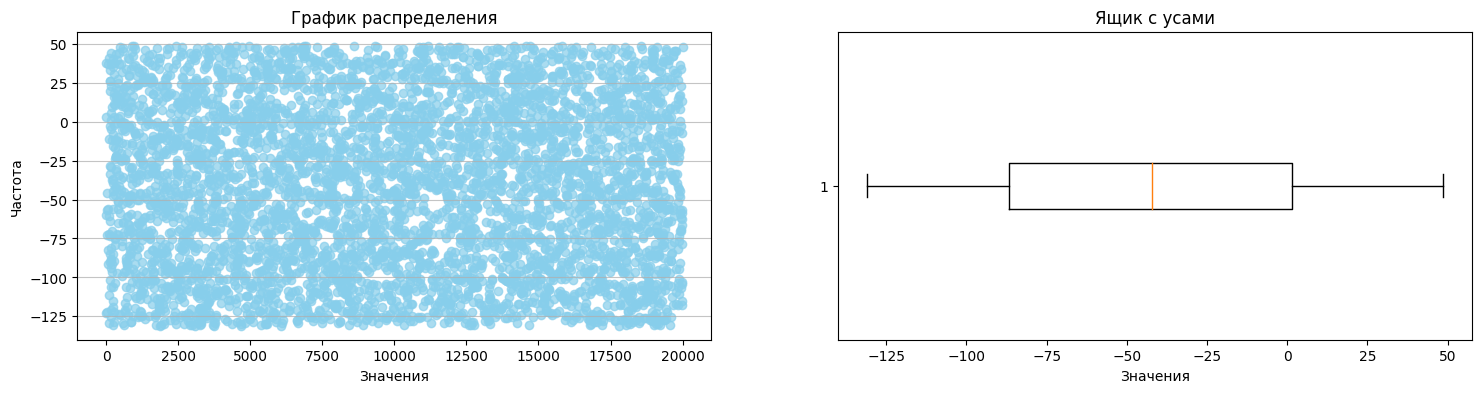

Для столбца 65:


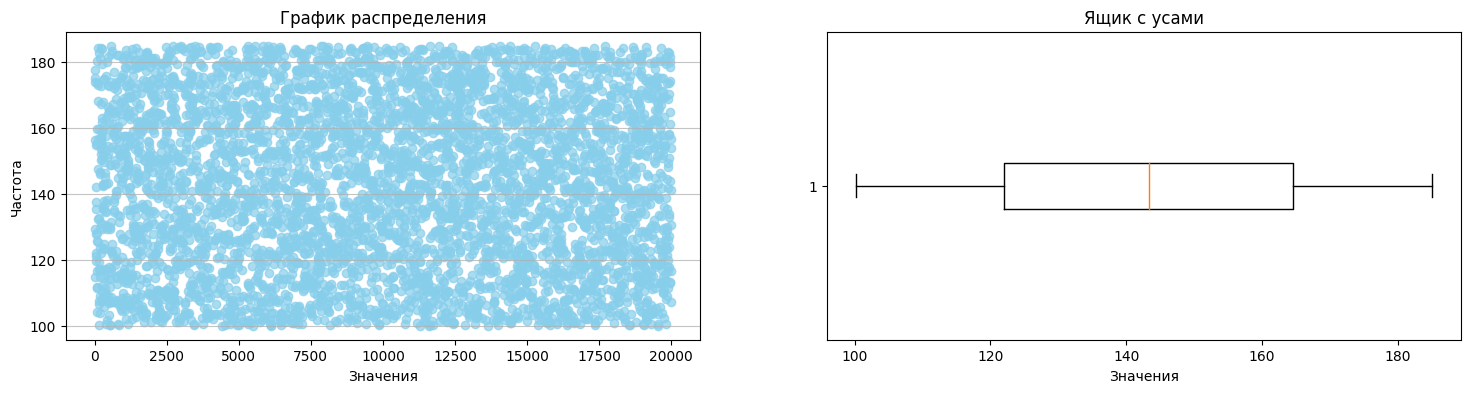

Для столбца 70:


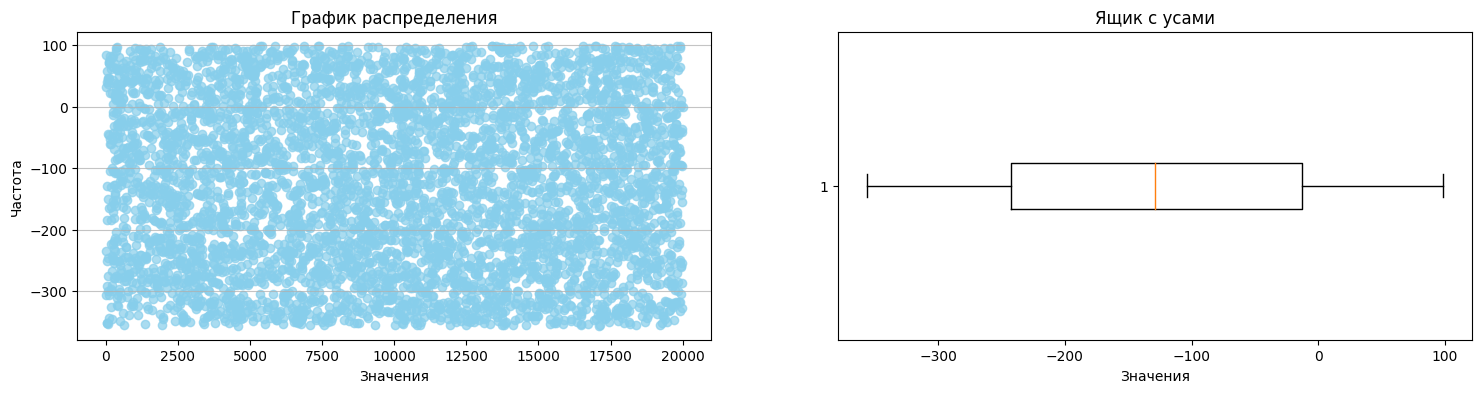

In [10]:
selected_columns = ['6', '21', '25', '33', '44', '59', '65', '70']

plot_distribution_and_boxplot(train, selected_columns)


In [11]:
def value_share(data, selected_columns):
  for column in selected_columns:
    top_values = data[column].value_counts().head(10)
    total_rows = len(data[column])

    # Расчет доли для каждого из топ-10 значений в каждом столбце
    print(f"Для столбца {column}:")
    for value, count in top_values.items():
        share = count / total_rows
        print(f"Значение: {value}, Процент: {share:.2%}")
    print("\n")

In [12]:
selected_columns = ['6', '21', '25', '33', '44', '59', '65', '70']
value_share(train, selected_columns)

Для столбца 6:
Значение: -759.62604, Процент: 20.73%
Значение: -530.1247, Процент: 6.58%
Значение: 62.154667, Процент: 0.10%
Значение: -463.13425, Процент: 0.04%
Значение: -366.47375, Процент: 0.03%
Значение: 64.48251, Процент: 0.03%
Значение: -750.15106, Процент: 0.02%
Значение: -164.98703, Процент: 0.02%
Значение: -754.25415, Процент: 0.02%
Значение: -292.02655, Процент: 0.02%


Для столбца 21:
Значение: 1507.2313, Процент: 64.31%
Значение: 1248.1262, Процент: 1.65%
Значение: 1342.6411, Процент: 1.19%
Значение: 1483.7141, Процент: 0.79%
Значение: 1425.6606, Процент: 0.74%
Значение: 1054.2056, Процент: 0.68%
Значение: 1502.1589, Процент: 0.62%
Значение: 1415.6588, Процент: 0.38%
Значение: 836.683, Процент: 0.33%
Значение: 1195.4479, Процент: 0.32%


Для столбца 25:
Значение: 813.7701, Процент: 82.99%
Значение: 175.5957, Процент: 0.71%
Значение: 701.22626, Процент: 0.25%
Значение: 635.15625, Процент: 0.11%
Значение: 108.05735, Процент: 0.04%
Значение: 812.91095, Процент: 0.03%
Значение


*   В train 100,000 строк и 72 признака
*   нет пропусков и дублей
*   для ускрения работы с df, изменим тип с float64 на float32
*   Распределение большинства признаков близко к нормальному(пик в центре, симметричные боковые стороны)
*   Столюцы ['6', '21', '25', '33', '44', '59', '65', '70'] отличаются от нормального распределения:
** столбец 6
Значения -759 и ~-530 выделяются. Они встречаются в 20% и 6% соответственно. Остальные значения распределены равномерно.
** столбец  21
Значение 1507 встречается почти в 65% случаев. Остальные значения распределены равномерно.
** столбец 25
Значение 813 встречается почти в 83% случаев. Остальные значения распределены равномерно.
** столбец 33
Самые часто встречаемое значение -156, -1018,-529 почти в равных долях представлет лишь 18% выборки. На графике распределения видим, чтоесть несколько чисел, вощле которых сгруппированы все значения, -137, -143, -153,-156, будто это подкатегории
** столбец 44
Аналогичная ситуация. На точечной диаграмме больше всего значений сгруппированы возле значения -16.43, еще около -16.25 и -16.07
в топ 10 вошло лишь одно значений с -16
** столбец 59 и 65
распределены нормально. Каждое из топ-10 не набирает даже 0.1%.
** столбец 70
Значение -1074  встречается почти в 23% случаев. Остальные значения распределены равномерно.





Первичный анализ base

base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

Размер:    (583600, 73)


'Первые 5 строк         '

Id           0          1           2          3          4  \
0   6-base -132.349780  12.640369  -80.635895 -137.11795  89.345490   
1  10-base  -98.898865   5.633918  -88.647285 -158.90100  87.810620   
2  12-base  -68.859090  -0.939237  -47.824863 -153.82768  89.371060   
3  13-base  -71.780470   9.491869  -80.955360 -105.35263  84.318450   
4  14-base -121.066216   6.920069 -134.866850 -132.77559  19.703812   

           5           6           7           8  ...         62         63  \
0 -94.853520 -462.934000   91.356030  126.557274  ... -55.650047  29.008305   
1 -76.610000    6.748629  -27.250978  126.672390  ... -81.505670  19.662066   
2 -83.141740 -529.278500   39.693317  118.244225  ... -58.820076  76.393720   
3 -78.632150 -429.259030  108.983040  124.514730  ... -29.982979  40.114300   
4 -37.102016   83.941820  -78.876540  125.779030  ... -64.943320  56.583214   

          64          65        66         67          68         69  \
0 -138.24612  156.300500  67.05420 -25.324776   85.734146  138.85352   
1 -125.73326   18.915530  67.41328  48.166084  146.343660  117.06042   
2 -180.40990   85.385710  67.94069 -20.363410  162.172640  120.76160   
3 -138.04740   59.624220  68.61810  71.057980   95.904850  141.27716   
4 -239.40808   76.244835  64.53448  66.593765  109.980560  141.34575   

          70          71  
0 -1070.5162   -2.041809  
1 -1152.3021  -73.153015  
2 -1092.4850  -64.907616  
3 -1205.3022  -51.975533  
4 -1074.4648 -156.521820  

[5 rows x 73 columns]

Типы полей:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583600 entries, 0 to 583599
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      583600 non-null  object 
 1   0       583600 non-null  float64
 2   1       583600 non-null  float64
 3   2       583600 non-null  float64
 4   3       583600 non-null  float64
 5   4       583600 non-null  float64
 6   5       583600 non-null  float64
 7   6       583600 non-null  float64
 8   7       583600 non-null  float64
 9   8       583600 non-null  float64
 10  9       583600 non-null  float64
 11  10      583600 non-null  float64
 12  11      583600 non-null  float64
 13  12      583600 non-null  float64
 14  13      583600 non-null  float64
 15  14      583600 non-null  float64
 16  15      583600 non-null  float64
 17  16      583600 non-null  float64
 18  17      583600 non-null  float64
 19  18      583600 non-null  float64
 20  19      583600 non-null  float64
 21

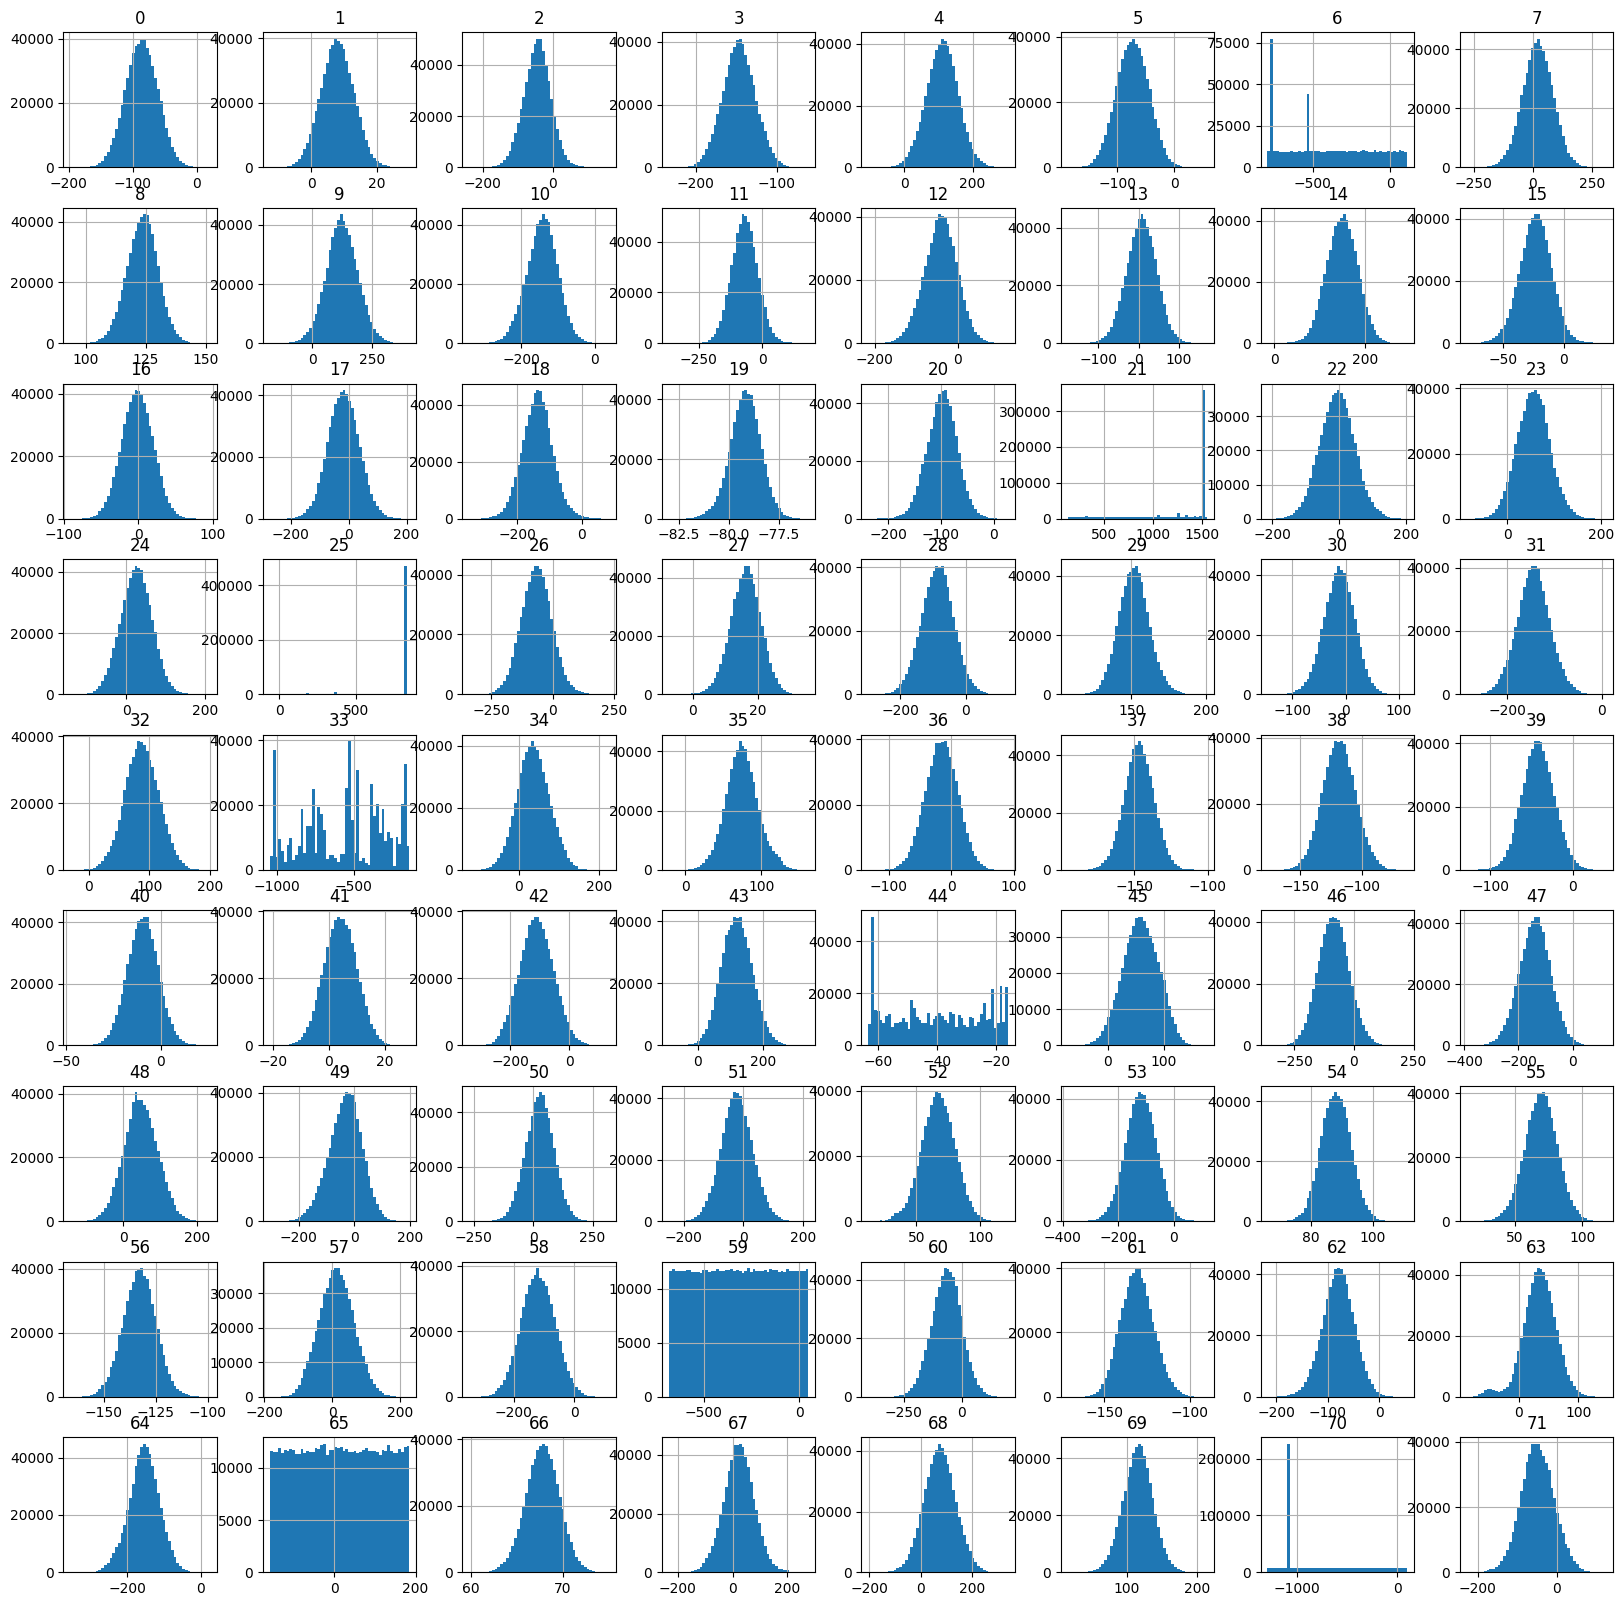

In [13]:
exploratory(base)

Для столбца 6:


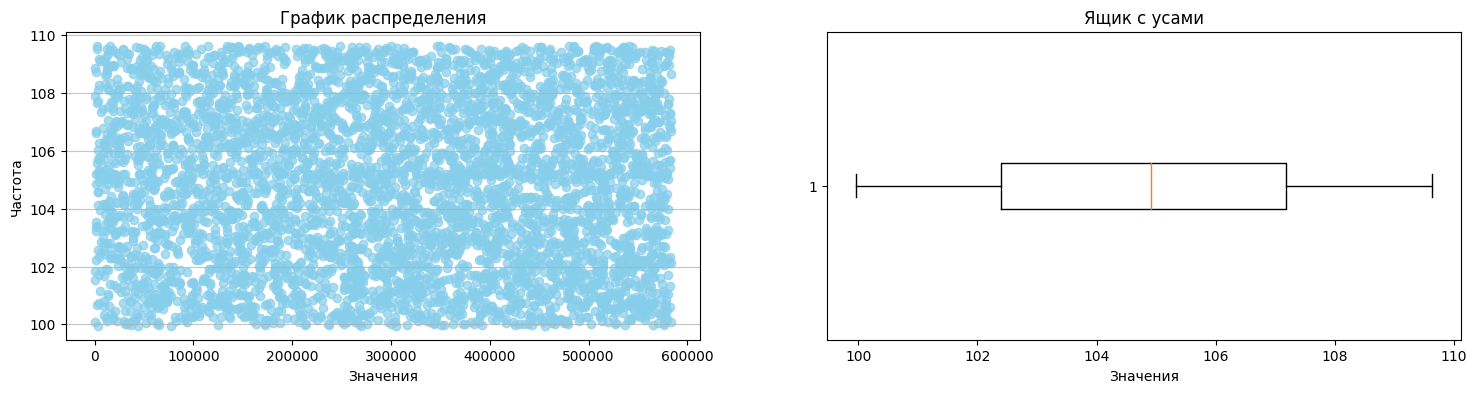

Для столбца 21:


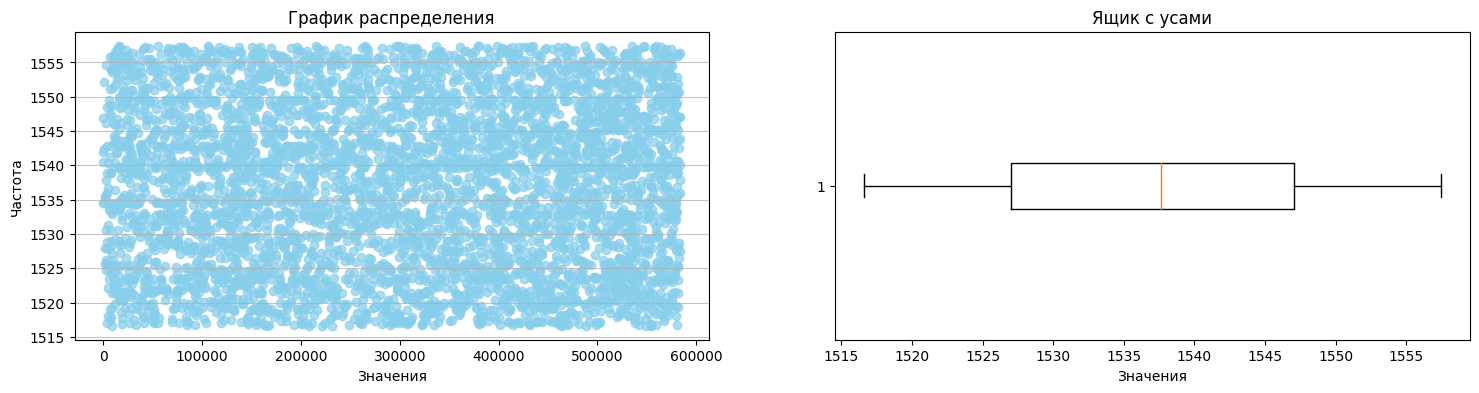

Для столбца 25:


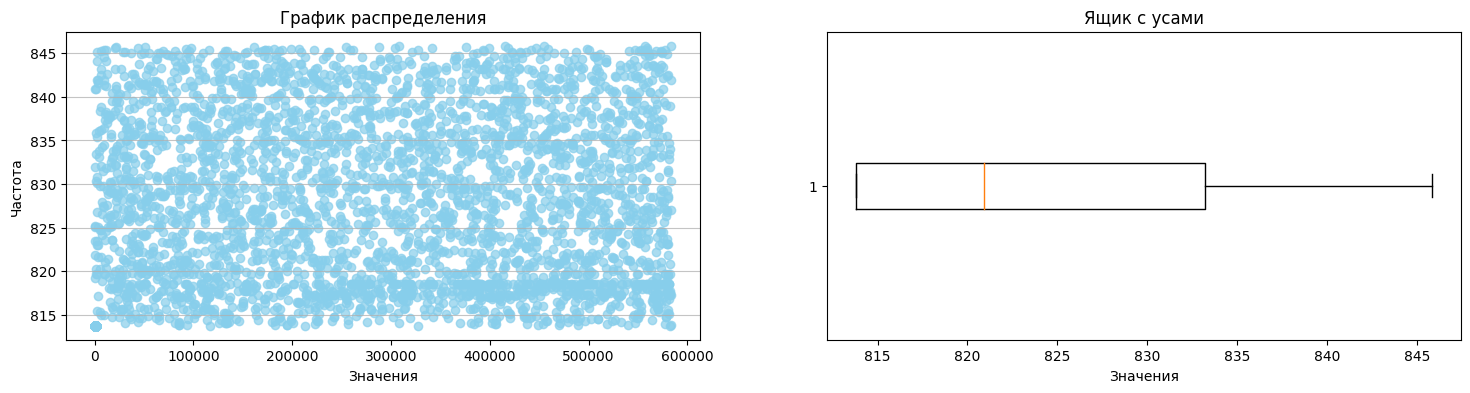

Для столбца 33:


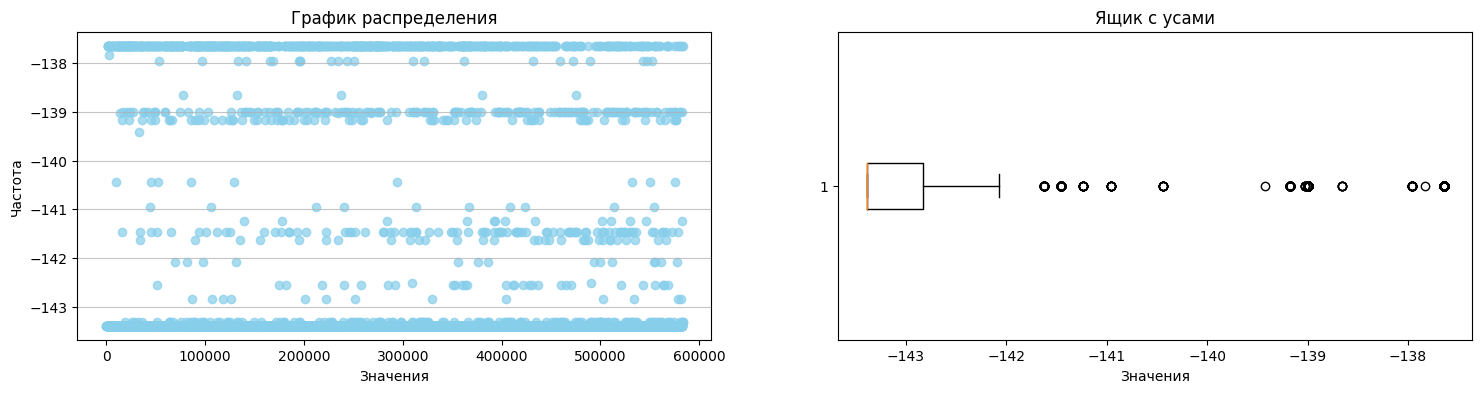

Для столбца 44:


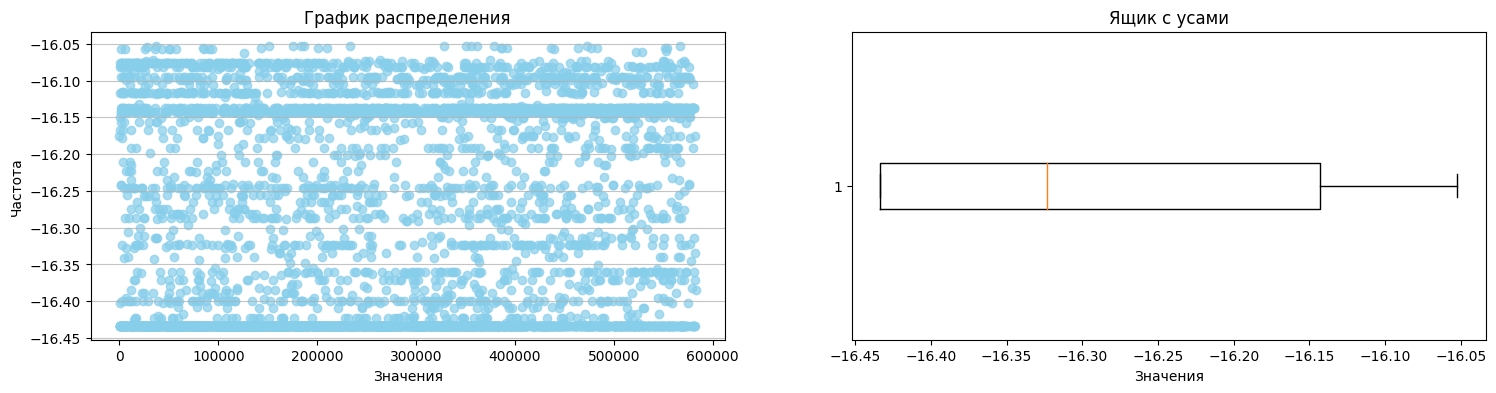

Для столбца 59:


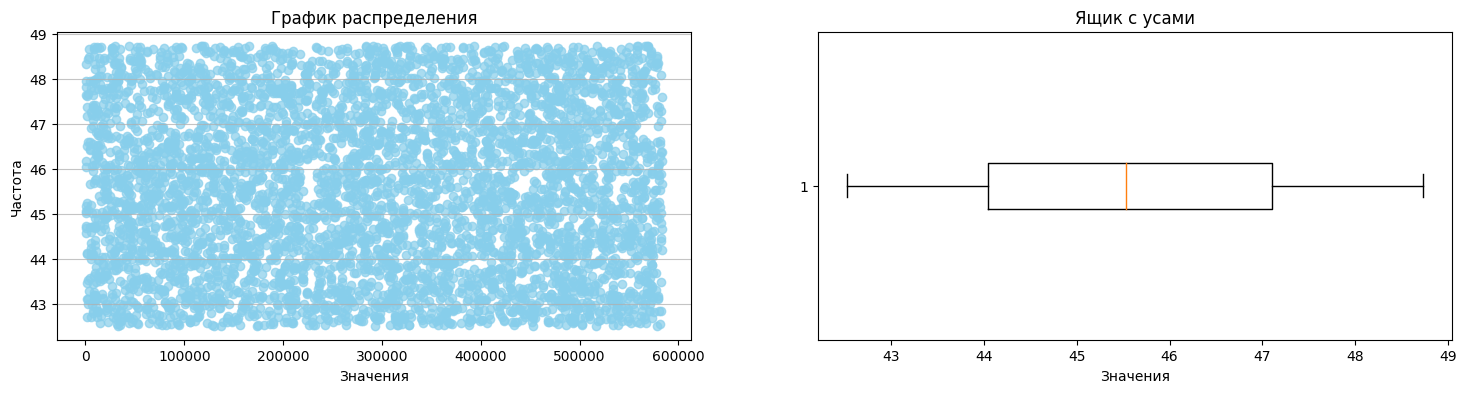

Для столбца 65:


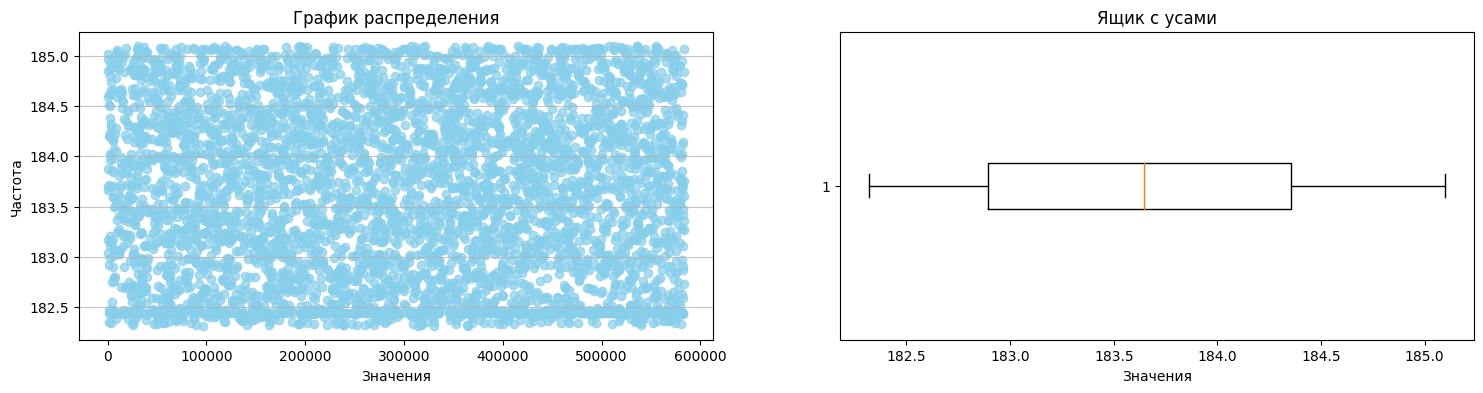

Для столбца 70:


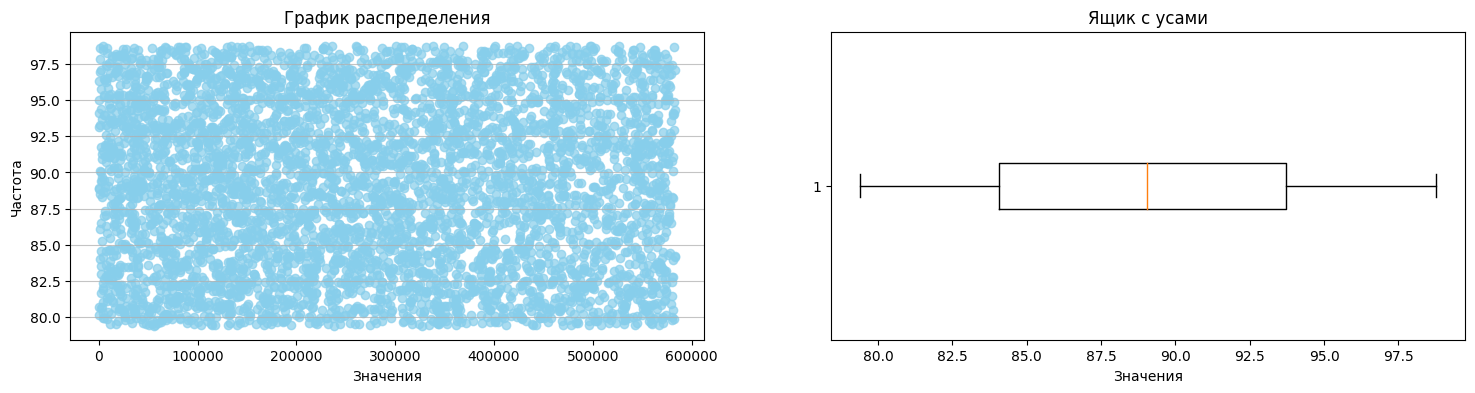

In [14]:
selected_columns = ['6', '21', '25', '33', '44', '59', '65', '70']
plot_distribution_and_boxplot(base, selected_columns)

In [15]:
selected_columns = ['6', '21', '25', '33', '44', '59', '65', '70']
value_share(base, selected_columns)

Для столбца 6:
Значение: -759.62604, Процент: 11.61%
Значение: -530.1247, Процент: 5.91%
Значение: -175.04785, Процент: 0.10%
Значение: -92.05512, Процент: 0.09%
Значение: 62.154667, Процент: 0.08%
Значение: -750.15106, Процент: 0.07%
Значение: -312.1494, Процент: 0.07%
Значение: -463.13425, Процент: 0.06%
Значение: -730.1639, Процент: 0.05%
Значение: -486.7752, Процент: 0.04%


Для столбца 21:
Значение: 1507.2313, Процент: 60.83%
Значение: 1248.1262, Процент: 1.48%
Значение: 1342.6411, Процент: 1.19%
Значение: 1483.7141, Процент: 0.82%
Значение: 1054.2056, Процент: 0.71%
Значение: 325.54712, Процент: 0.43%
Значение: 1415.6588, Процент: 0.40%
Значение: 1258.5365, Процент: 0.37%
Значение: 1195.4479, Процент: 0.29%
Значение: 836.683, Процент: 0.27%


Для столбца 25:
Значение: 813.7701, Процент: 80.66%
Значение: 366.77957, Процент: 1.10%
Значение: 175.5957, Процент: 0.33%
Значение: 701.22626, Процент: 0.08%
Значение: 635.15625, Процент: 0.05%
Значение: 514.9551, Процент: 0.03%
Значение: 8

Значения отличаются, но выводы по ним аналогичны train

Первичный анализ *validation*
validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

Размер:    (20000, 73)


'Первые 5 строк         '

Id          0         1          2          3           4  \
0  100004-query  -79.53292 -0.364173 -16.027431 -170.88495  165.453920   
1  100005-query  -89.74536  6.317698 -80.744650 -114.53197  153.960340   
2  100007-query -119.02685  7.536469 -62.973827 -142.94609  150.376110   
3  100010-query  -57.71042  5.344710 -36.634872 -151.92635  123.258860   
4  100013-query -113.83982  5.682194  -7.384804 -142.80922   63.082832   

           5           6          7           8  ...          62         63  \
0 -28.291668   33.931934  34.411217  128.903980  ... -123.770250  45.635944   
1 -74.897130 -208.928700 -32.214005  115.582855  ...  -64.934890  37.824436   
2 -92.343550 -530.124700  24.280703  124.623260  ... -121.699980  49.379295   
3 -82.446480 -530.124700  54.023262  118.234550  ...  -61.568954  35.105920   
4 -69.850624 -759.626040  31.846502  120.052260  ...  -60.315765  45.007620   

          64          65        66          67         68          69  \
0 -134.25893   13.735359  70.61763   15.332115  154.56812  101.700640   
1 -153.04173 -131.257920  68.26281   56.239280  120.64690   76.342550   
2 -211.29207   37.299725  68.56667   21.038134   37.36427  116.667170   
3 -134.64563   -7.372177  69.39937   16.125835  202.46930  120.868460   
4 -147.07414   34.577280  65.68382  251.287280   96.05116  110.661316   

           70          71  
0 -1171.89230 -125.307890  
1 -1156.99290  -72.146390  
2 -1129.24290  -87.194520  
3  -195.12244 -121.981840  
4  -560.48190  -13.711834  

[5 rows x 73 columns]

Типы полей:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      20000 non-null  object 
 1   0       20000 non-null  float64
 2   1       20000 non-null  float64
 3   2       20000 non-null  float64
 4   3       20000 non-null  float64
 5   4       20000 non-null  float64
 6   5       20000 non-null  float64
 7   6       20000 non-null  float64
 8   7       20000 non-null  float64
 9   8       20000 non-null  float64
 10  9       20000 non-null  float64
 11  10      20000 non-null  float64
 12  11      20000 non-null  float64
 13  12      20000 non-null  float64
 14  13      20000 non-null  float64
 15  14      20000 non-null  float64
 16  15      20000 non-null  float64
 17  16      20000 non-null  float64
 18  17      20000 non-null  float64
 19  18      20000 non-null  float64
 20  19      20000 non-null  float64
 21  20      20000 non-null 

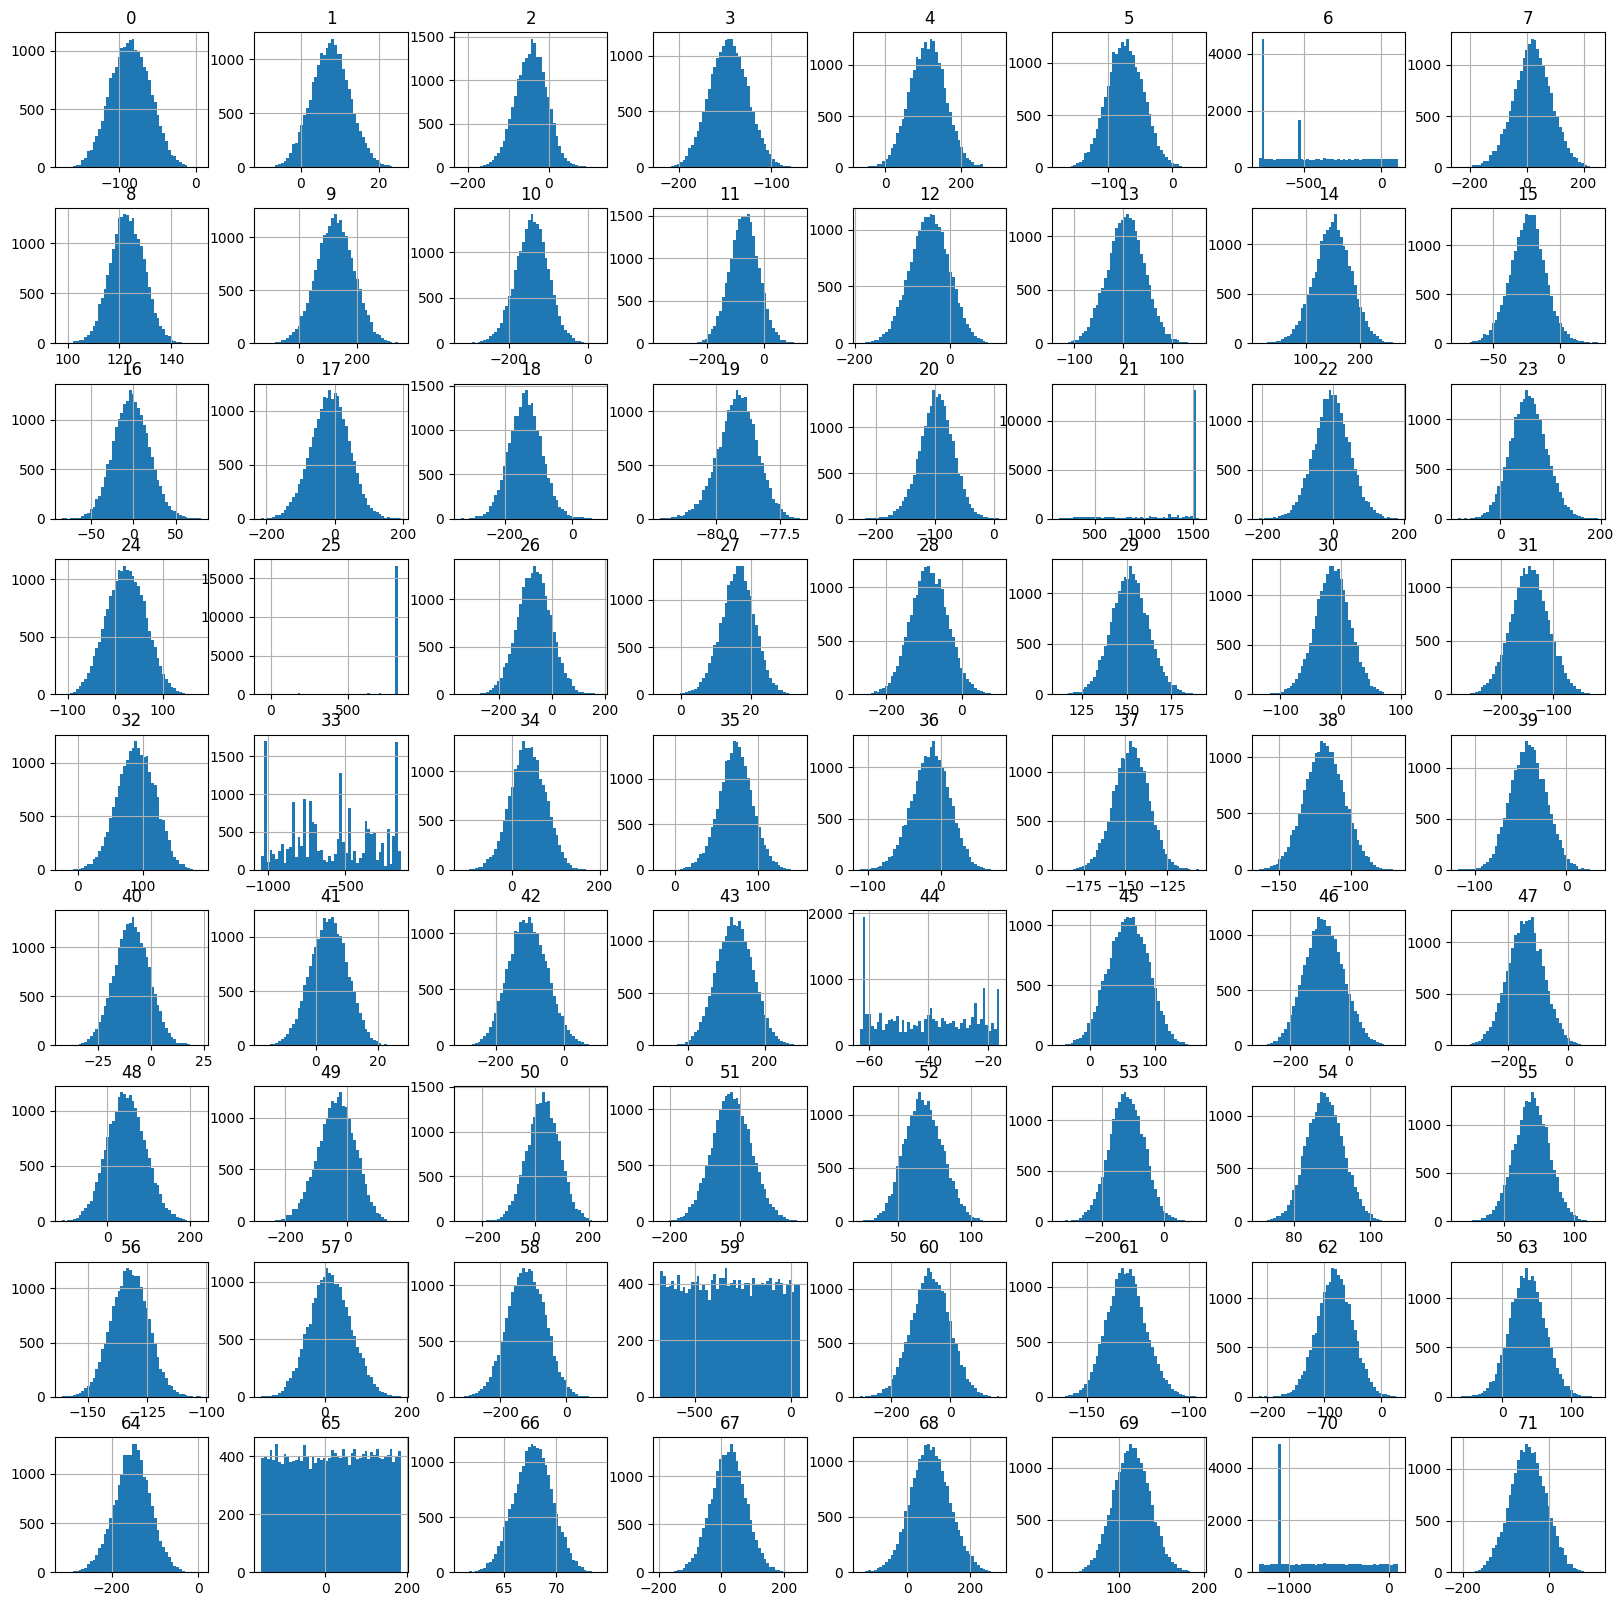

In [18]:
exploratory(validation)

Для столбца 6:


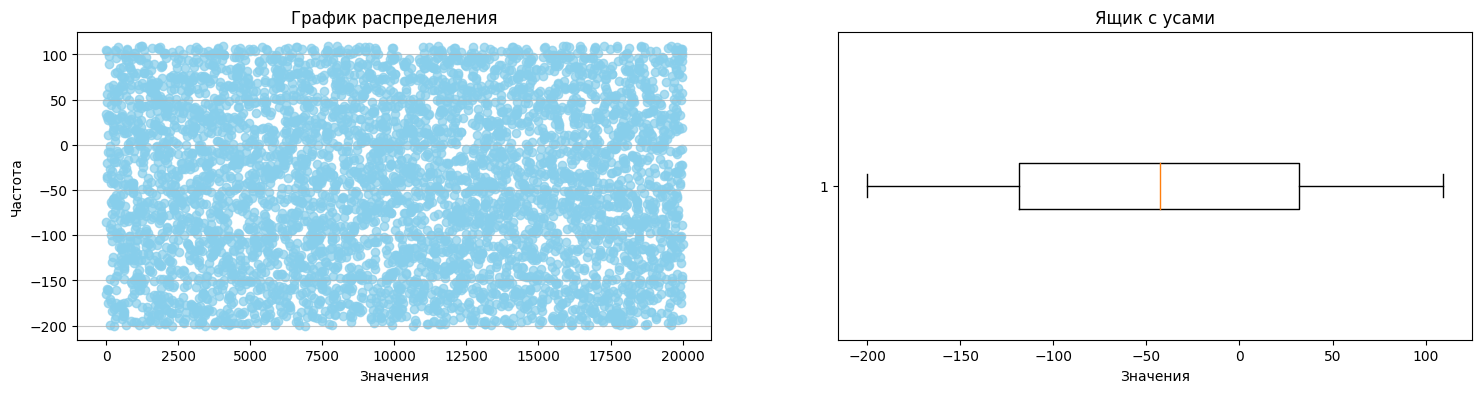

Для столбца 21:


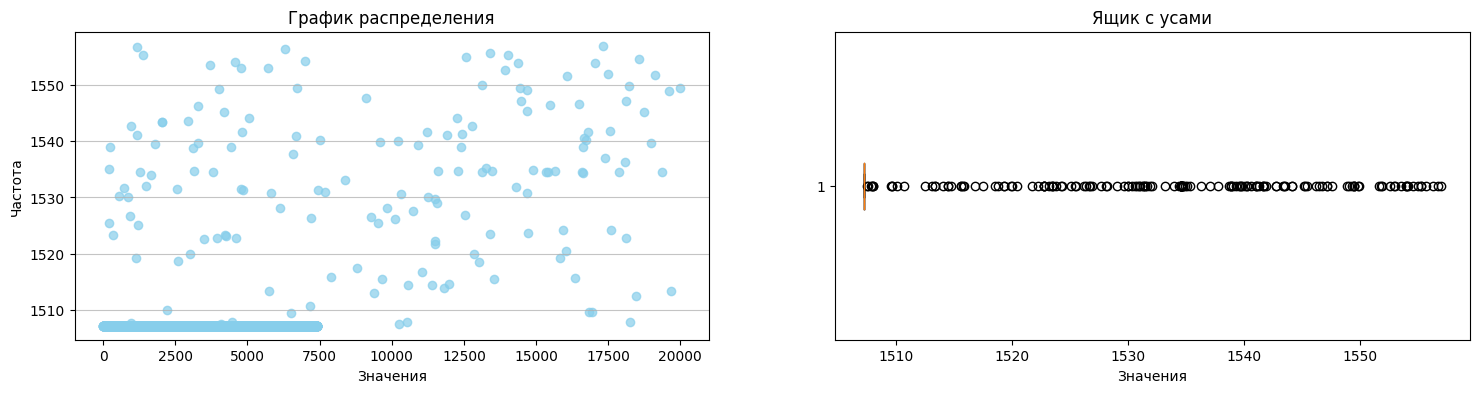

Для столбца 25:


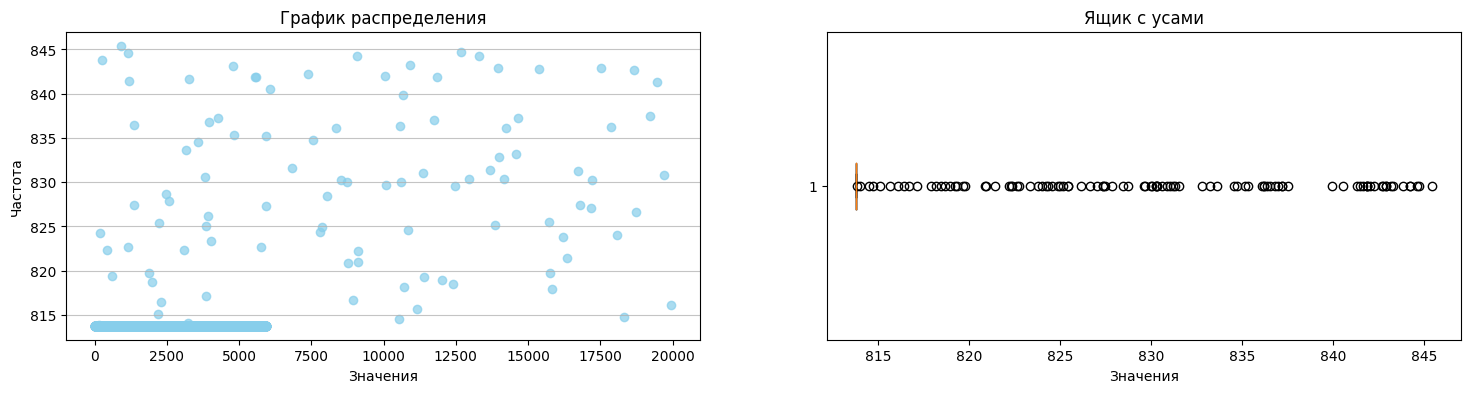

Для столбца 33:


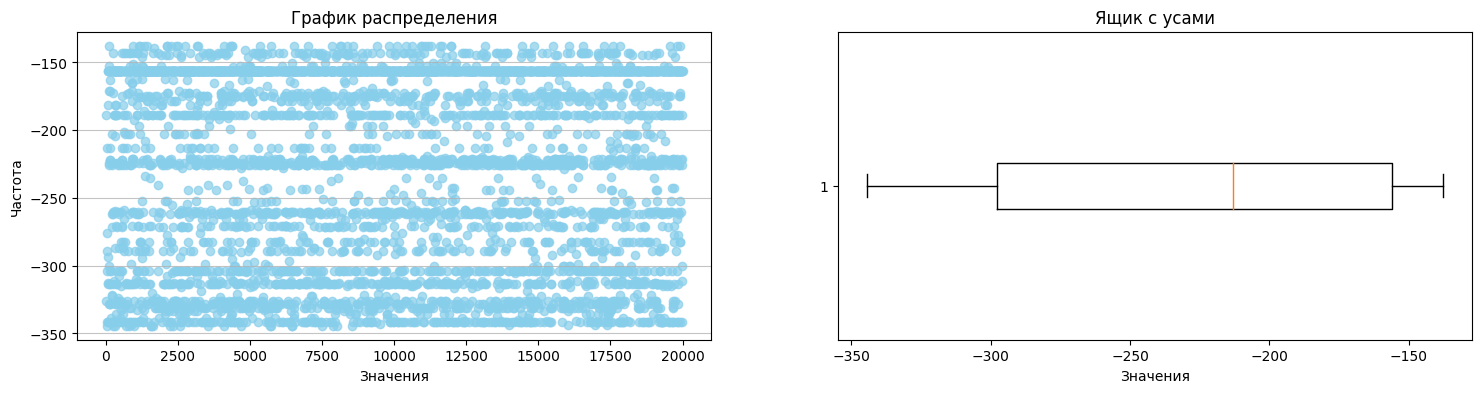

Для столбца 44:


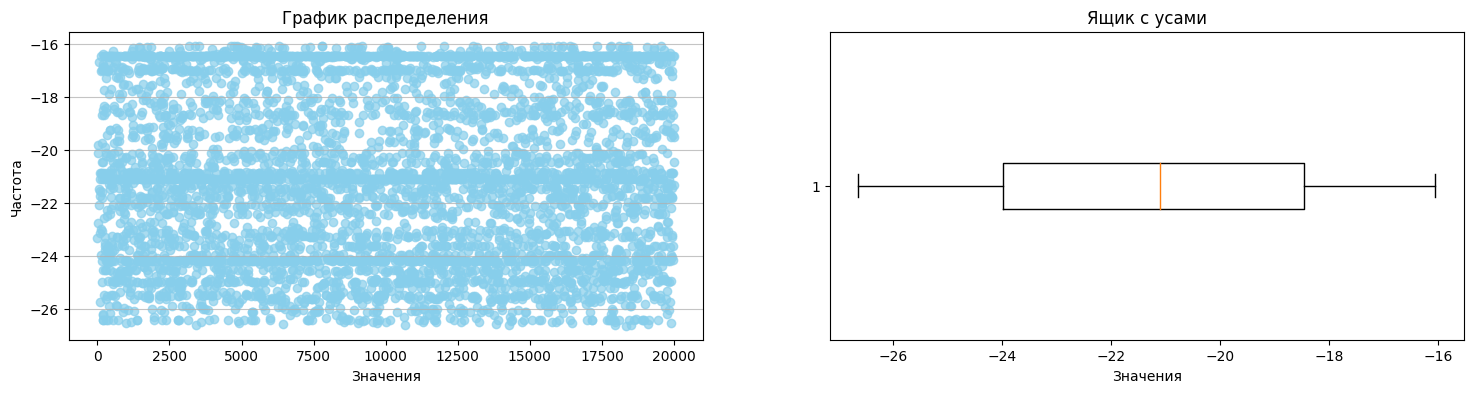

Для столбца 59:


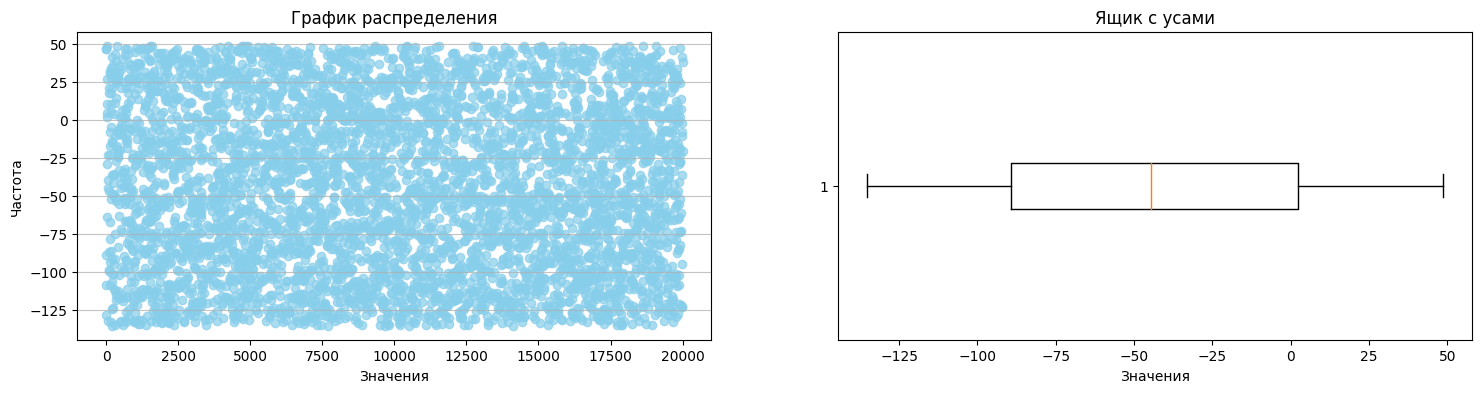

Для столбца 65:


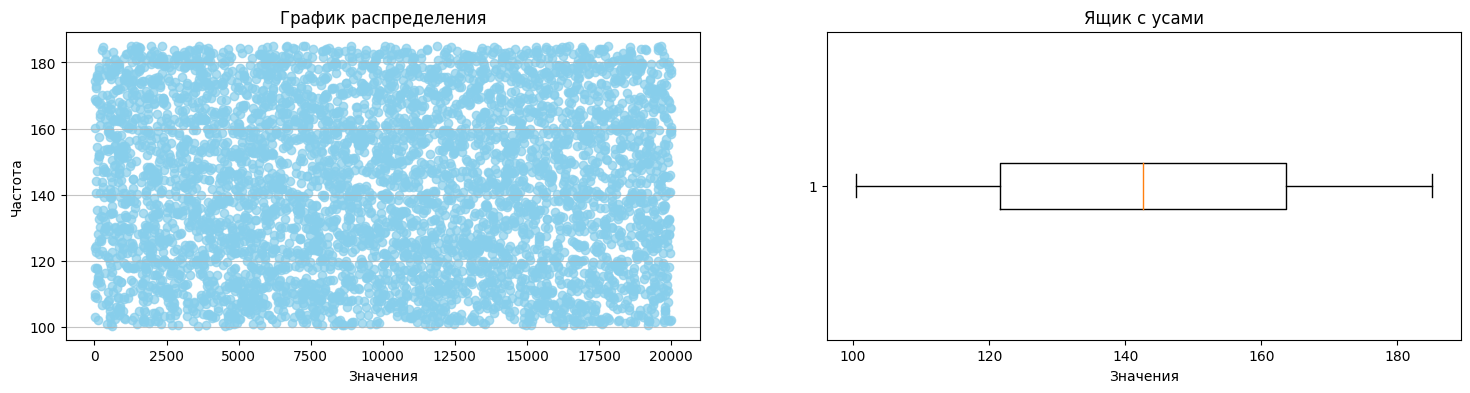

Для столбца 70:


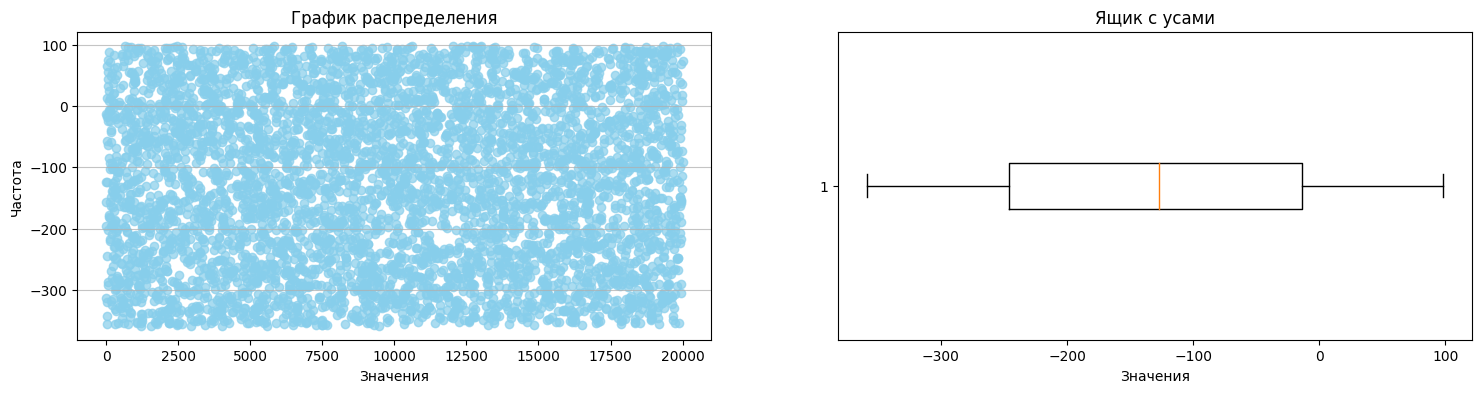

In [19]:
selected_columns = ['6', '21', '25', '33', '44', '59', '65', '70']
plot_distribution_and_boxplot(validation, selected_columns)

In [20]:
selected_columns = ['6', '21', '25', '33', '44', '59', '65', '70']
value_share(validation, selected_columns)

Для столбца 6:
Значение: -759.62604, Процент: 21.20%
Значение: -530.1247, Процент: 6.85%
Значение: 62.154667, Процент: 0.10%
Значение: 64.48251, Процент: 0.03%
Значение: -648.3203, Процент: 0.03%
Значение: -366.47375, Процент: 0.03%
Значение: -292.02655, Процент: 0.02%
Значение: -739.2113, Процент: 0.01%
Значение: -403.9638, Процент: 0.01%
Значение: -476.96982, Процент: 0.01%


Для столбца 21:
Значение: 1507.2313, Процент: 64.67%
Значение: 1248.1262, Процент: 1.66%
Значение: 1342.6411, Процент: 1.29%
Значение: 1483.7141, Процент: 0.77%
Значение: 1054.2056, Процент: 0.73%
Значение: 1502.1589, Процент: 0.66%
Значение: 1425.6606, Процент: 0.52%
Значение: 1415.6588, Процент: 0.36%
Значение: 1250.4237, Процент: 0.33%
Значение: 836.683, Процент: 0.30%


Для столбца 25:
Значение: 813.7701, Процент: 82.85%
Значение: 175.5957, Процент: 0.69%
Значение: 701.22626, Процент: 0.18%
Значение: 635.15625, Процент: 0.10%
Значение: 84.29004, Процент: 0.04%
Значение: 196.52298, Процент: 0.03%
Значение: 77

Выводы аналогичны train.
Видим, что 3 df похожи логикой построения. Отличие лишь в размерах выборок

## Подготоавливаем словарь для корректной загрузки типов данных. По умолчанию загружается float64, мы используем float32

In [ ]:
train = train.astype({col: 'float32' for col in train.select_dtypes(include=['float64']).columns})
validation = validation.astype({col: 'float32' for col in validation.select_dtypes(include=['float64']).columns})
base = base.astype({col: 'float32' for col in base.select_dtypes(include=['float64']).columns})

Первичный анализ *validation_answer*

validation_answer - правильные ответы к validation

In [16]:
print(f"Размер:    {validation_answer.shape}")
display("Первые 5 строк         ", validation_answer.head())
print(f"Типы полей:")
print(validation_answer.info())
print(f"Описательная статистика:")
print(validation_answer.describe())
print("Пропущенные значения, %:         ", validation_answer.isna().sum()/len(validation_answer.index)* 100)
print("Дубли построчно:   ", validation_answer.duplicated().sum())

Размер:    (20000, 2)


'Первые 5 строк         '

Id      Expected
0  100004-query    75484-base
1  100005-query  1905037-base
2  100007-query  1533713-base
3  100010-query   641788-base
4  100013-query    11032-base

Типы полей:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        20000 non-null  object
 1   Expected  20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB
None
Описательная статистика:
                  Id     Expected
count          20000        20000
unique         20000        19605
top     100004-query  268435-base
freq               1            4
Пропущенные значения, %:          Id          0.0
Expected    0.0
dtype: float64
Дубли построчно:    0


In [17]:
selected_columns = ['Expected']
value_share(validation_answer, selected_columns)


Для столбца Expected:
Значение: 268435-base, Процент: 0.02%
Значение: 86720-base, Процент: 0.01%
Значение: 229321-base, Процент: 0.01%
Значение: 682686-base, Процент: 0.01%
Значение: 560191-base, Процент: 0.01%
Значение: 59354-base, Процент: 0.01%
Значение: 112488-base, Процент: 0.01%
Значение: 97790-base, Процент: 0.01%
Значение: 191129-base, Процент: 0.01%
Значение: 1694836-base, Процент: 0.01%






*   100,000 строк и 2 признака
*   нет пропусков и дублей
*   Количество уникальных значений меньше общего количества -> одному товару из base может соответствовать несколько из validation

Общий вывод после первичного анализа

*   3 аналогичных df (train, validation, base)
*   все df без дублей и пропусков
*   изменили тип с float64 на float32

*  Значения сильно отличаются. Для того, чтобы модель на это не ориентировалась, сделаем масштабирование





## Масштабирование

**Вопрос ревьюеру**
Как бороться с выбросами в этом примере?

StandardScaler is sensitive to outliers https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

В предыдущих проектах после преобразования количество выбросов сводилось к минимуму (в большинстве случаев удалял значения, иногда группировал по более важным признакам и заменял выбросы). В этом df, как мне кажется, нет возможности поработать с выбросами. Вы бы просто оставили выбросы, (особенно столбцы 21 и 25) и на этапе стандартизации использовали не stanartScaler (масштабирует относительно среднего и стандартного отклонения), а RobustScaler (масштабирует относительно медианы и межквартильного распределения) outliers can often influence the sample mean / variance in a negative way. In such cases, using the median and the interquartile range often give better results https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

P.S. уже написав код и поднявшись к блоку импортов, увидел, что RobustScaler уже был импортирован наставником в заготовке кода


в блоке ниже получаб ошибку : could not convert string to float: '0-base'. В руководстве не нашел переменной, отвечабщий за исключение столбцов: вместо 70 столюцов х 10,000 строк использую 69 столбцов и 10000 строк.
поэтому создадим словарь вида {0 : 0-base} и удалим Id и выведем 1 значение как список

In [23]:
index_dict = {k: v for k, v in enumerate(base['Id'])}
list(index_dict.items())[0]

(0, '6-base')

In [74]:
for df in [base, train, validation, validation_answer]:
    #сначала удалял их. Для ранжирования понял, что без id не обойтись
    #поэтому решение - индексировать по id
    #df = df.drop('Id', axis=1,  inplace=True)
    df = df.set_index('Id', inplace=True)  # Изменение индекса

In [25]:
train.head()

0          1          2          3          4           5  \
Id                                                                            
1-query   -87.77637   6.806268 -32.054546 -177.26039  120.80333  -83.810590   
14-query -107.74551   8.262278   1.303707 -122.30960  124.88633 -113.067260   
17-query  -64.54115   6.379174  22.827354 -140.19008  118.12147  -45.949470   
21-query  -41.34329  12.988533 -52.500470 -177.08405  117.42550  -64.219170   
24-query -133.16289  -2.366189 -24.341312 -163.20690  136.80786  -64.591225   

                  6           7          8           9  ...         62  \
Id                                                      ...              
1-query   -94.57275  -78.433090  124.91590  140.331070  ... -40.812233   
14-query -759.62604  -50.134230  125.86170  107.053070  ... -77.386720   
17-query -167.82553   76.232230  116.56160   36.988052  ... -99.924270   
21-query -759.62604  119.854680  116.59877   28.824615  ... -48.169018   
24-query -759.62604    0.566725  121.06721  166.230510  ... -66.291520   

                 63         64          65         66         67         68  \
Id                                                                            
1-query    4.669178 -151.69771   -1.638704  68.170876  25.096191  89.974976   
14-query  19.192116 -169.01462  129.329820  69.071840 -21.853165  91.174060   
17-query  68.939440 -232.42427 -151.365800  66.982070  21.464298  31.847046   
21-query  33.574203 -140.07430  -74.130066  70.309480  22.298388  53.082397   
24-query  21.065586 -151.60904   21.146963  71.008780 -37.431760  57.041412   

                  69          70          71  
Id                                            
1-query   130.589630 -1035.09220  -51.276833  
14-query   86.220680  -951.97925 -119.347946  
17-query  125.621956 -1179.73110  -48.768707  
21-query  113.545525  -653.41100    8.083492  
24-query  141.719480 -1181.58060  -36.334442  

[5 rows x 72 columns]

In [26]:
scaler = RobustScaler()
# вычисляю медианы и межквартильное распределение по столбцам
scaler.fit(base)

RobustScaler()

In [27]:
scaler.fit(base)

RobustScaler()

In [28]:
# применение масштабирование
base_transform  = scaler.transform(base)

In [29]:
train_transform = scaler.transform(train)

In [30]:
validation_transform = scaler.transform(validation)

In [31]:
validation_transform

array([[ 0.18902215, -1.23143338,  0.54706459, ..., -0.50338836,
        -0.25058887, -1.37086741],
       [-0.10906144, -0.2413481 , -0.73724074, ..., -1.40296151,
        -0.22623265, -0.42144354],
       [-0.96373785, -0.06075688, -0.38458092, ...,  0.02754629,
        -0.18086942, -0.69019167],
       ...,
       [ 0.63085453, -0.08294191,  0.02672   , ...,  0.0961024 ,
        -0.09132305, -0.4493002 ],
       [ 0.36638096,  0.42358747,  0.29779891, ...,  0.76708056,
         1.51550524, -0.06839498],
       [ 0.78179143,  0.83560751,  1.31471483, ..., -0.63733588,
         1.78458242,  0.36552742]])

** Использование Faiss для поиска соседей**

https://github.com/facebookresearch/faiss/tree/main
https://faiss.ai/index.html



Faiss (Facebook AI Similarity Search) - это библиотека, разработанная Facebook, которая предназначена для выполнения быстрого и эффективного поиска ближайших соседей в больших наборах данных с высокой размерностью. Принцип работы Faiss основан на использовании индексов и алгоритмов, специально разработанных для ускорения операций поиска ближайших соседей.

Вот общий принцип работы Faiss:

Индексирование: Сначала данные (например, векторы признаков) индексируются с использованием различных алгоритмов индексации, предоставляемых Faiss. Это создает структуры данных, которые позволяют быстро находить ближайшие векторы к данному запросу.

Поиск: Когда появляется запрос на поиск ближайших соседей для заданного вектора, Faiss использует ранее построенный индекс для эффективного нахождения наиболее близких векторов в наборе данных. Этот поиск может быть выполнен с использованием различных методов, включая методы перебора, инвертированные списки и другие.

Другими словами, находим вектора, где евклидово расстояние минимально.

In [32]:
#https://github.com/facebookresearch/faiss/blob/main/tutorial/python/1-Flat.py
#https://habr.com/ru/companies/okkamgroup/articles/509204/

# инициализация индекса
dimensions = base_transform.shape[1]
n_clusters = 20
quantizer = faiss.IndexFlatL2(dimensions)
idx_l2 = faiss.IndexIVFFlat(quantizer, dimensions, n_clusters)

In [33]:
#обучаем индекс, используя массив значений из base_transform.
idx_l2.train(np.ascontiguousarray(base_transform).astype('float32'))

#деление
#индекс строит внутреннюю структуру данных, которая позволяет быстро выполнять поиск ближайших соседей
idx_l2.add(np.ascontiguousarray(base_transform).astype('float32'))

In [59]:
# измерим время поиска
#start_time = time.time()
# Получим предсказания на тестовых данных
vectors, train_idx = idx_l2.search(np.ascontiguousarray(train_transform).astype('float32'), 20)

In [107]:
 # функция вычисления accuracy@n
def accuracy_n(targets, predict, index_dict):
    count = 0
    n = len(targets)
    for target, candidates in zip(targets.tolist(), predict.tolist()):
        count += int(target in [index_dict[number] for number in candidates])

    return 100*count / n

In [ ]:
print('accuracy@{}: {:.2f}%'.format(20, accuracy_n(train_targets, train_idx, index_dict)))


accuracy@20: 46.72%


повторим вычисление accuracy для топ-5

In [35]:
vectors, train_idx = idx_l2.search(np.ascontiguousarray(train_transform).astype('float32'), 5)

**Вопрос ревьюеру**
accuracy слишком низкое. Что можно было сделать для его повышения?

изменять n_clusters/RobustScaler на другой Scaler/кросс-валидация напрямую не предусмотрена

In [ ]:
print('accuracy@{}: {:.2f}%'.format(5, accuracy_n(train_targets, train_idx, index_dict)))


accuracy@5: 44.22%


**Вопрос ревьюеру**
Кажется, что 70 столбцов для сверки -это очень много для сравнения 2 товаров.
Можно было построить матрицу корреляции и удалить столбцы с самой высокой корреляцией. Было 70 столбцов, стало ~10.

Когда построил корреляцию между всеми 72 столюцами 100,000 строк, корреляция между ними стремится к 0.

Если бы так сделал, вы могли бы засчитать работу, или сказали бы, что в корне не верно? Если не верно, то почему?
Если верно, то используя Faiss, рассмотртеь 72 столбца как 72 вектора, и для каждого найти наименьшее расстояние с другими? Это и будут дублирующие столбцы.


Попробовал начать так делать, но появились вопросы из-за размерности

In [ ]:
train_limit = train.iloc[:5, :5]
"""
это лишь образец кода. Он не отрабоатет корректно, т.к. столбец сам на себя покажем корреляцию в 1-цу.
корреляцию всех строк на все строки будем очень долго ждать
сократив таблицу до размера 5х5, получил корреляция в 0.8
2 столбец с 0 столбцом
3 столбец с 4 столбцом
"""

threshold = 0.8
high_corr_columns = []

for column in train_limit.columns:
    corr_values = train.corr(method='spearman')[column]
    high_corr = corr_values[(corr_values > threshold) | (corr_values < -threshold)].index.tolist()
    high_corr_columns.extend(high_corr)

high_corr_columns = list(set(high_corr_columns))  # убираем дубликаты

print("Столбцы с высокой корреляцией (более 80%):")
print(high_corr_columns)


Столбцы с высокой корреляцией (более 80%):
['0', '2', '4', '3', '1']


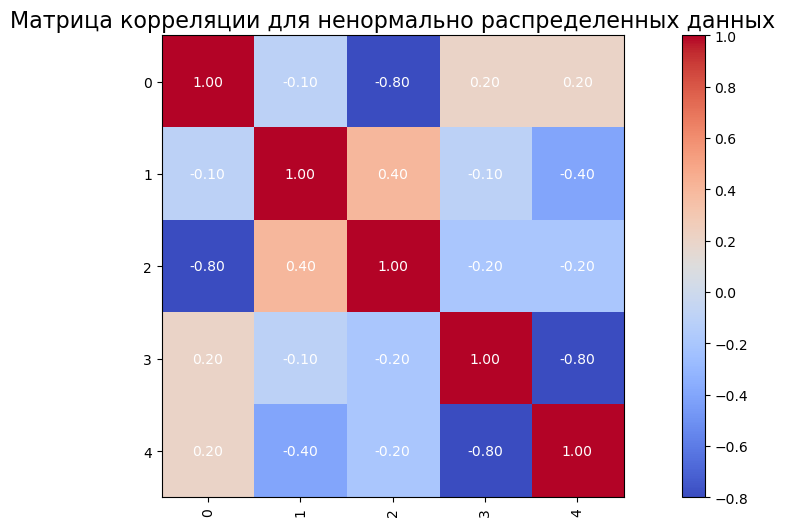

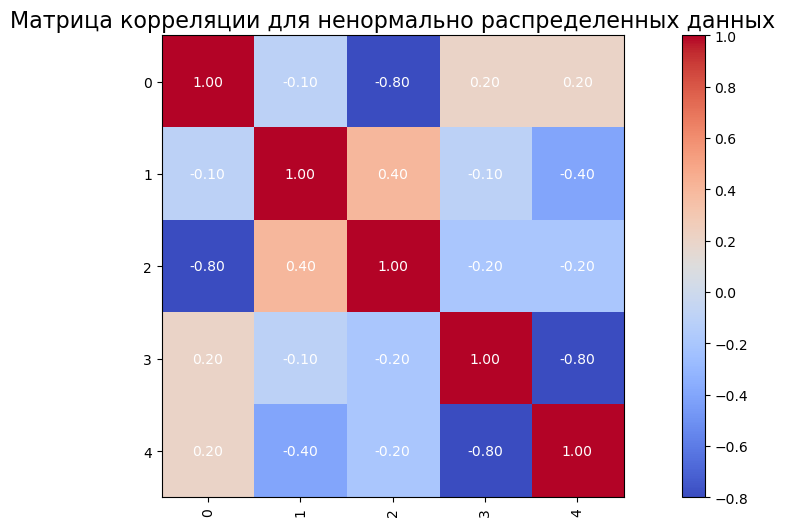

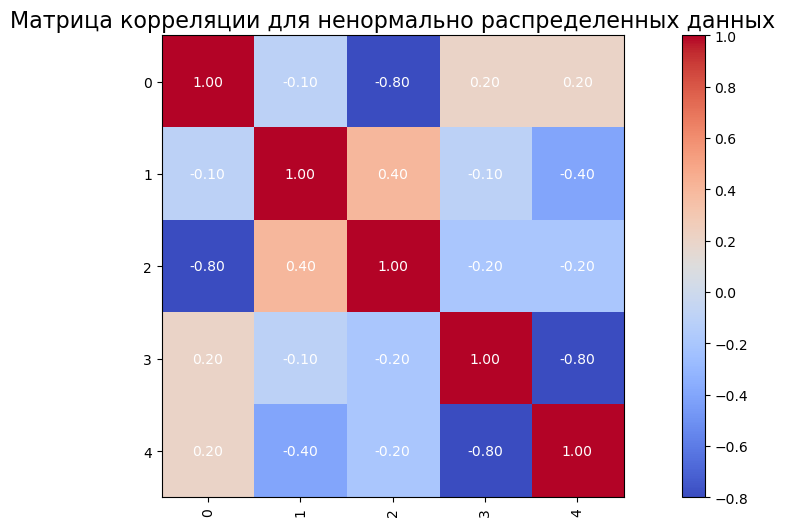

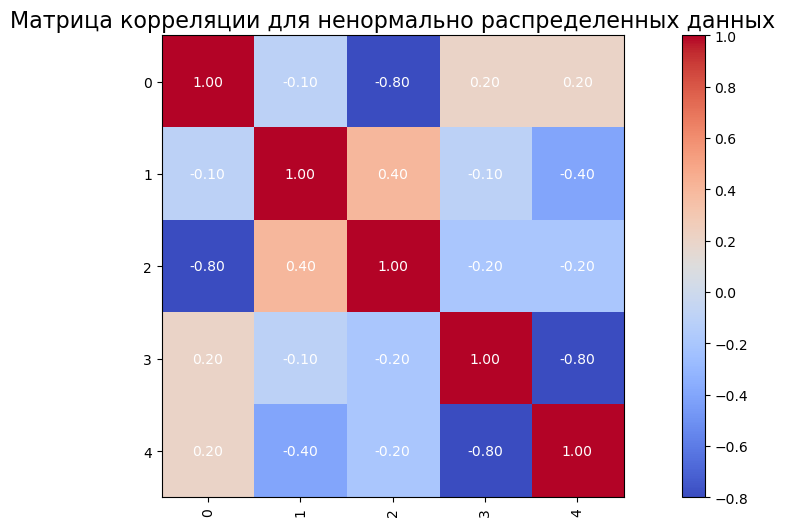

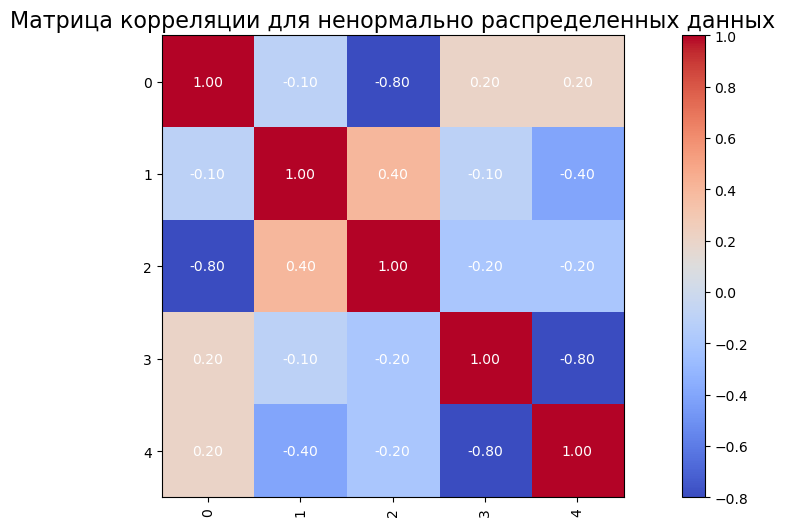

In [ ]:
for column in train_limit.columns:
    # Вычисление матрицы корреляции
    corr_matrix = train_limit.corr(method = 'spearman')
    # Визуализация матрицы корреляции
    plt.figure(figsize=(15, 6))
    #в более высоком разрешений очен долго строит

    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    tick_marks = [i for i in range(len(train_limit.columns))]
    plt.xticks(tick_marks, corr_matrix.columns, rotation='vertical')
    plt.yticks(tick_marks, corr_matrix.columns)
    # Добавление текстовых аннотаций
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            plt.text(i, j, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='w')
    plt.title('Матрица корреляции для ненормально распределенных данных', fontsize=16)
    plt.show()

In [ ]:
#построил корреляцию между всеми 72 столюцами 100,000 строк, корреляция между ними стремится к 0.
train_without_col   = train
train_without_col = pd.DataFrame(train_without_col)

n_features = 72

# Инициализация индекса Faiss
index_without_col = faiss.IndexFlatL2(n_features)

# Добавление данных в индекс
index_without_col.add(train_without_col)

# Вычисление расстояний между столбцами
distances, _ = index_without_col.search(train_without_col, 2)

# Поиск корреляции между столбцами
correlation_matrix = train_without_col.corr(method = 'spearman').abs()

correlation_matrix

Как видим, если использовать 100,000 строк имеют корреляцию между собой в районе 0.01.

#в этом коде 100,000 разбиваю на несколько подтаблиц
#Код отключил, т.к. есть вопрос в следующем блоке.

train_without_col   = train
train_without_col = pd.DataFrame(train_without_col)

# Загрузка большой таблицы с 100,000 строками

# Разделение большой таблицы на несколько подтаблиц
n_subtables = 5  # Количество подтаблиц
subtable_size = len(train_without_col) // n_subtables

subtables = []
for i in range(n_subtables):
    start_index = i * subtable_size
    end_index = (i + 1) * subtable_size
    subtable = train_without_col.iloc[start_index:end_index]
    subtables.append(subtable)

# Вычисление корреляции внутри каждой подтаблицы
correlations = []
for subtable in subtables:
    correlation_matrix = subtable.corr()
    correlations.append(correlation_matrix)

    
for i in range(len(subtables)):
    subtables[i] = subtables[i].reset_index(drop=True)
    
    
# Вычисление кросс-корреляции между подтаблицами
cross_correlations = []
for i in range(n_subtables):
    for j in range(i+1, n_subtables):
        cross_corr = subtables[i].corrwith(subtables[j])
        cross_correlations.append((i, j, cross_corr))

# Вывод результатов
for i, j, cross_corr in cross_correlations:
    print(f"Cross-correlation between subtable {i} and subtable {j}:\n{cross_corr}")


**Вопрос ревьюеру**
3 вопроса:
1) Реализация не простая. Возможно есть готовые библиотеки для перекрестнойб кросс-валидации матриц. Я не нашел:(
2) Из-за большого объема выборки разбиваю ее на подвыборки. До какого объема лучше всего уменьшать выборки? Когда по 100 строк, корреляци будет более сильная, чем для 1000. Что должно быть мерилом? Разделил бы все по 2 строки, и корреляция между столбцами была бы в районе 1. Но это же наверно не верно.

3)Если изначальный df разбиваю на 3 подтаблицы, после выполнения кода выше будет 3 матрицы корреляции (1я со 2й, 1я с 3ей, 2я с 3ей). Столбцы во всех 3 матрицах одни и те же, но значения в них разные. Потом в рамках группы по 3 значения (корреляция n столюца на j столбец для 3 матриц) беру значения по модулю и нахожу медиану по группе?
Или вы как бы решали?

Сейчас способ с удалением строк приостанавливаю. Много вопросов и так мало ответов(

Для 47% из train найдено 20 сопосоталений, один из которых целевой.
Для 44% из train найдено 5 сопосотавлений, один из которых целевой.
Сократить выборку в 4 раза и потерять всего 3% accuracy. Значит большая часть предсказаний Faiss приходится на топ-5 предсказаний.

По условиям задачи, нужно выбрать топ-5. Поэтому перейдем к ранжированию

## Ранжирование##

У нас есть по 5 предсказаний на каждый товар, содержащиеся в train_idx. К этим предсказанием добавим подписи из изначальной таблицы train
Получим таблицу с предсказаниями и столбцами. Предсказания идут сверху вниз друг за другом по группам, сначала 5 предсказания для первого товара, 5 предсказаний для второго товара. Получили таблицу 1 товар - 5 аналогов.

Полученную таблицу left join к таблице с товарами, которые предсказывали.
Изнпачальные 100,000 строк превратятся в 500,000, столюцы с признаками удвоятся.
Сверим по id товара. Если предсказание совпадает с id, то укажем флаг 1, иначе 0.

Эту таблицу передадим модели и далее.

P.S. часа 2 с боем пробирался через несколько простых операций. С таблицей хорошо работать, когда она в голове и все чудесным образом происходит так, как надо. Поэтому каждый шаг подписывал. Правильнее было бы в одну строчку сделать матрицу нужным размером и заполнить ее смещением +1 к значению на каждые 5 строк из транспонированной train_idx, а не это

In [ ]:
train_idx

array([[ 336969,  598613, 2360257,   13374,  480296],
       [ 737853,  902634,  220644,  134844,  298805],
       [ 173120, 1784963, 1143288,  137853, 1368891],
       ...,
       [1733416, 2703195,  700937,  258295,  382092],
       [ 905282, 2358202, 2078497,  448293,  296059],
       [1958647, 1831967,   48897,  750263,  623734]], dtype=int64)

In [ ]:
train.index

Index(['0-query', '1-query', '2-query', '3-query', '4-query', '5-query',
       '6-query', '7-query', '8-query', '9-query',
       ...
       '99990-query', '99991-query', '99992-query', '99993-query',
       '99994-query', '99995-query', '99996-query', '99997-query',
       '99998-query', '99999-query'],
      dtype='object', name='Id', length=100000)

In [ ]:
train_idx.shape

(100000, 5)

In [ ]:
train.head()

0          1           2          3           4           5  \
Id                                                                             
0-query -53.882748  17.971436  -42.117104 -183.93668  187.517490  -87.144930   
1-query -87.776370   6.806268  -32.054546 -177.26039  120.803330  -83.810590   
2-query -49.979565   3.841486 -116.118590 -180.40198  190.128430  -50.837620   
3-query -47.810562   9.086598 -115.401695 -121.01136   94.652840 -109.255410   
4-query -79.632126  14.442886  -58.903397 -147.05254   57.127068  -16.239529   

                  6          7           8           9         10          11  \
Id                                                                              
0-query -347.360606  38.307602  109.085560   30.413513  -88.08269  -52.695540   
1-query  -94.572749 -78.433090  124.915900  140.331070 -177.60580  -84.995514   
2-query   26.943937 -30.447489  125.771164  211.607820  -86.34656  -35.666546   
3-query -775.150134  79.186520  124.003100  242.650650 -146.51707 -159.469850   
4-query -321.317964  45.984676  125.941284  103.392670 -107.15302   -8.800034   

                12         13          14         15         16          17  \
Id                                                                            
0-query -27.692442   4.872923  198.348000 -30.075249  -3.803569 -135.810610   
1-query  42.810810 -57.256332   96.792534 -19.261467   0.739535   50.619213   
2-query  16.395317 -80.802850  137.908650 -23.532760 -47.256584  -16.650242   
3-query -13.844755  -6.113928  118.939255 -44.585907   9.559358   14.435648   
4-query -50.977800  29.457338  143.389310   5.614824 -45.274760    9.643625   

                18         19        20           21         22          23  \
Id                                                                            
0-query -161.84137 -78.512180 -94.42894   898.436927 -70.140520   78.420360   
1-query -155.26703 -78.659430 -92.76149   353.157741 -34.744545   82.487110   
2-query -194.50568 -78.372925 -69.32448  1507.231274 -52.500970  -34.165775   
3-query -156.90683 -78.789320 -78.73709  1507.231274  19.957405   34.834290   
4-query  -77.55463 -79.066610 -77.92646  1507.231274  16.612400  116.284290   

                 24          25          26         27          28         29  \
Id                                                                              
0-query  108.032776  813.770071  -74.790880  12.610422 -183.821840  149.71584   
1-query  -28.450592  813.770071 -137.529630  26.595627 -136.783450  153.35791   
2-query   52.958652  813.770071  -18.021725  20.951107  -50.321780  158.76062   
3-query   -8.820732  813.770071 -125.606800  17.584084  -58.452904  141.28180   
4-query   33.754898  813.770071 -105.765335   6.523008  -19.812988  157.69392   

                30         31          32           33        34         35  \
Id                                                                            
0-query -27.042316 -133.21217  106.420746  -303.939233  48.73079  58.185707   
1-query  48.810093 -115.92215   87.464220  -222.286354  25.12415  91.887140   
2-query   0.178065 -183.06967   99.053570 -1018.469545 -51.80112  97.766770   
3-query -54.959310 -136.98854   63.880493 -1018.469545  89.22893  65.919960   
4-query -20.604088 -146.59128   78.849570  -780.449185  87.56077  73.036660   

                36         37          38         39         40        41  \
Id                                                                          
0-query  24.250950 -151.22410 -104.282265 -34.492810 -12.587054  2.622891   
1-query -30.636870 -136.59314 -140.500120 -43.449757  -7.226884  8.265747   
2-query -10.865850 -144.42316 -133.819490 -78.902300 -17.200352  4.467452   
3-query -24.078644 -152.33410  -91.199380 -28.225390  -4.767386  0.158236   
4-query  16.891030 -144.65790 -116.122150 -19.353254  -7.709266 -5.394988   

                 42         43         44          45          46         47  \
Id                                    

In [81]:
#К предсказанием добавим подписи из изначальной таблицы train
# Данные для построения DataFrame
train_for_merge_data = train_idx
train_for_merge_index = train.index
# Создание DataFrame train_for_merge
train_for_merge = pd.DataFrame(data=train_for_merge_data, index=train_for_merge_index)
train_for_merge

0       1       2       3       4       5       6       7   \
Id                                                                            
1-query      187713  143550    3163  197372   95497  485855  230477  426369   
14-query      24734  509689  111444  377214  425675    3593  511113  228918   
17-query     416115  202829  380664   76038  154719  442247   70608   39236   
21-query     362422  272432   17627   51060  192997  374734   33562   29053   
24-query     468357  349948  536484   75233  275614  532728  352909  301607   
...             ...     ...     ...     ...     ...     ...     ...     ...   
99984-query  416746  402083  188106  200231  284921  405526  182862  302942   
99989-query  202006  482433  247849  211174  206844  143021  188424  504513   
99990-query  144089   83548  193205  392008  437024  404076  151407   28720   
99991-query  319804  394263  381021  521115  510985  550027  456381    9720   
99995-query   83552  149225   95185   94616  258783  427844  578233  432183   

                 8       9       10      11      12      13      14      15  \
Id                                                                            
1-query      110685  480012   62205  203780  120927  411027  371376  547376   
14-query     457184   86555  459478  239466  531407  415869  429391  418987   
17-query      14313  325728   51693   69801  355642  380159  263372  578832   
21-query     180115  151207   59702  534852  243700  243891  212381   62832   
24-query     576216  235710  420687  498873  270330  512378  182665  206012   
...             ...     ...     ...     ...     ...     ...     ...     ...   
99984-query   73258   48223   78610  383272   65752  173397  420346  314202   
99989-query  453100  469641   65225  410997    3171  240550  303858  387182   
99990-query  467940  129376  455188  530771  560061  118445  150720  295294   
99991-query  116168  542569  212734  526738   83486  290685  423660  468670   
99995-query  518626  367543  386792  545262  454768     683  108355  298721   

                 16      17      18      19  
Id                                           
1-query       66703     439  324560  373511  
14-query     362566  111197  331789  185457  
17-query     513952  285378   94271  373485  
21-query      28586   29120  102141  293877  
24-query     175709  227134   67324  152115  
...             ...     ...     ...     ...  
99984-query  291253  104843  510423  196065  
99989-query  318671   27785  258909  153326  
99990-query   31680  537373  388639  218936  
99991-query  329631   28947  354602   12137  
99995-query   55263  257426  147733  514017  

[20000 rows x 20 columns]

Теперь нужно транспонировать, т.к. движемся к размеру 500,000 строк

In [82]:
train_for_merge = train_for_merge.T

train_for_merge.shape

(20, 20000)

вот на этом моменте план чуть не пошел не по плану, т.к. не смог вспомнить название melt
![image.png](attachment:image.png)

In [83]:
train_for_merge = pd.melt(train_for_merge)

train_for_merge.shape

(400000, 2)

In [ ]:
train_for_merge.head()
"""
каждому value есть свое значение из index_dict, например index_dict[500000]  = '553985-base'
пропущенных значений быть не долнжо, т.к. учили модель на конкретных значениях и только из них должна была предсказать
опрашиваем по столюцу value и ищем соответствие в словаре index_dict
и этим значением заполняем новый столбец
сначала хотел через left join, но тогда нужно словарь превращать в df и лишь потом left join.
Экономлю время на одном шаге.
"""

"\nкаждому value есть свое значение из index_dict, например index_dict[500000]  = '553985-base'\nпропущенных значений быть не долнжо, т.к. учили модель на конкретных значениях и только из них должна была предсказать\nопрашиваем по столюцу value и ищем соответствие в словаре index_dict\nи этим значением заполняем новый столбец\nсначала хотел через left join, но тогда нужно словарь превращать в df и лишь потом left join.\nЭкономлю время на одном шаге. Как потом выяснится, превращение словаряв df все равно потребуется\n"

In [84]:
train_for_merge['id_assumption'] = [index_dict[number] for number in train_for_merge['value'].values]

In [ ]:
train_for_merge.head(7)

Id    value id_assumption
0  0-query   336969   361564-base
1  0-query   598613   675816-base
2  0-query  2360257  3543241-base
3  0-query    13374    13406-base
4  0-query   480296   530165-base
5  1-query   737853   854272-base
6  1-query   902634  1075687-base

- сейчас у нас пара id id_assumption в таблице train_for_merge
- заполним их соответствубщими значениями

In [ ]:
train_targets

Target
0       675816-base
1       366656-base
2      1447819-base
3      1472602-base
4       717819-base
...             ...
99995   811868-base
99996  1460772-base
99997  2366140-base
99998     9252-base
99999  2769109-base

[100000 rows x 1 columns]

In [ ]:
train_targets[train_targets['Target'] == '0-query']

Empty DataFrame
Columns: [Target]
Index: []

In [ ]:
#dict_df.shape

(2918139, 2)

In [66]:
train1 = pd.read_csv('train_mini.csv')
train1 = train1[['Id', 'Target']]

In [ ]:
#4 обращения для перепроверки будущих join
#ищу, чем заполнить value и	id_assumption
train_for_merge.head()

variable    value id_assumption
0         0   336969   361564-base
1         0   598613   675816-base
2         0  2360257  3543241-base
3         0    13374    13406-base
4         0   480296   530165-base

In [ ]:
#train1[train1['Target']=='675816-base']

Id          0          1          2          3          4         5  \
0  0-query -53.882748  17.971436 -42.117104 -183.93668  187.51749 -87.14493   

            6          7          8          9        10        11         12  \
0 -347.360606  38.307602  109.08556  30.413513 -88.08269 -52.69554 -27.692442   

         13       14         15        16         17         18        19  \
0  4.872923  198.348 -30.075249 -3.803569 -135.81061 -161.84137 -78.51218   

         20          21        22        23          24          25        26  \
0 -94.42894  898.436927 -70.14052  78.42036  108.032776  813.770071 -74.79088   

          27         28         29         30         31          32  \
0  12.610422 -183.82184  149.71584 -27.042316 -133.21217  106.420746   

           33        34         35        36        37          38        39  \
0 -303.939233  48.73079  58.185707  24.25095 -151.2241 -104.282265 -34.49281   

          40        41         42         43        44        45         46  \
0 -12.587054  2.622891 -120.96992  149.99164 -31.94847  82.31443 -115.83047   

          47        48         49        50         51         52         53  \
0 -243.30939  6.622036 -132.19766  68.71256 -38.806824  62.937435 -132.65445   

          54        55         56        57         58         59        60  \
0  89.189026  87.03978 -121.27988 -6.986934 -206.51382  29.485587 -77.02959   

          61         62        63         64          65        66       67  \
0 -132.38617 -105.42782  70.10736 -155.80257 -101.965943  65.90379  34.4575   

          68        69          70         71       Target  
0  62.642094  134.7636 -415.750254 -25.958572  675816-base

In [79]:
#AttributeError: 'numpy.ndarray' object has no attribute 'head'
#сейчас __transform нужно преобразовать в df
# и подписать названия столбцов, котоые возьмем из df для __transform
#использую __transform, т.к. в дальнейшем эта таблица будет использована в ml -> нужны отмасшабированные данные
#Для заполнения предсказания
base_transform_df  = pd.DataFrame(base_transform,  index=base.index)
#base_transform_df.head()

In [77]:
#аналогично. Для заполнения target
train_transform_df  = pd.DataFrame(train_transform,  index=train.index)
#train_transform_df[train_transform_df['Id']=='0-query'].head()
#train_transform_df.head()

In [85]:
# в 2 шага объединение base и train по заготовленным id
#к целевому признаку добавляю его зарактеристики
train_base_df = train_for_merge.merge(train_transform_df, left_on='Id', right_on='Id', how='left')
#к предсказания добавляю характеристики
train_base_df = train_base_df.merge(base_transform_df, left_on='id_assumption', right_on='Id', how='left')
#добавляю таргета и построение бинарной классификации для обучения модели
train_base_df = train_base_df.merge(train1, left_on='Id', right_on='Id', how='left')

Если значение предсказания id_assumption совпало с Target, то укажем 1, иначе 0.


In [87]:
#Задача матчинга (соответствия)
train_base_df['match'] = train_base_df.apply(lambda row: 1 if row['id_assumption'] == row['Target'] else 0, axis=1)
#train_base_df.head(3)

In [88]:
y_train = train_base_df['match']
X_train= train_base_df.drop(['match', 'Target'] , axis=1)

Теперь повторим для валидационной выборки

In [89]:
vectors, valid_idx = idx_l2.search(np.ascontiguousarray(validation_transform), 20)


In [90]:

#К предсказанием добавим подписи из изначальной таблицы vector
# Данные для построения DataFrame
valid_for_merge_data = valid_idx
valid_for_merge_index = validation.index
# Создание DataFrame train_for_merge
valid_for_merge = pd.DataFrame(data=valid_for_merge_data, index=valid_for_merge_index)
valid_for_merge = valid_for_merge.T
valid_for_merge = pd.melt(valid_for_merge)
valid_for_merge['id_assumption'] = [index_dict[number] for number in valid_for_merge['value'].values]


In [91]:
validation_transform_df = pd.DataFrame(validation_transform, index=validation.index)

In [92]:
# в 2 шага объединение base и validation по заготовленным id
#к целевому признаку добавляю его зарактеристики
validation_base_df = valid_for_merge.merge(validation_transform_df, left_on='Id', right_on='Id', how='left')
#к предсказания добавляю характеристики
validation_base_df = validation_base_df.merge(base_transform_df, left_on='id_assumption', right_on='Id', how='left')
#добавляю таргета и построение бинарной классификации для обучения модели
validation_base_df = validation_base_df.merge(validation_answer, left_on='Id', right_on='Id', how='left')

In [52]:
validation_base_df.head()

Id   value id_assumption       0_x       1_x       2_x       3_x  \
0  100004-query  137918   584769-base  0.189022 -1.231433  0.547065 -0.903835   
1  100004-query  341349  1940163-base  0.189022 -1.231433  0.547065 -0.903835   
2  100004-query  422922  2710113-base  0.189022 -1.231433  0.547065 -0.903835   
3  100004-query  130002   544169-base  0.189022 -1.231433  0.547065 -0.903835   
4  100004-query  373102  2219328-base  0.189022 -1.231433  0.547065 -0.903835   

        4_x      5_x       6_x  ...      63_y      64_y      65_y      66_y  \
0  0.856791  1.12885  0.975579  ... -0.101031  1.018361 -0.290028  0.824802   
1  0.856791  1.12885  0.975579  ...  0.715799  0.762880 -0.467706  0.683902   
2  0.856791  1.12885  0.975579  ...  0.571660  1.292732 -0.932035  0.353056   
3  0.856791  1.12885  0.975579  ...  0.218553  0.811044  0.023336 -0.125542   
4  0.856791  1.12885  0.975579  ...  0.700841  0.598694 -0.958528  0.212709   

       67_y      68_y      69_y      70_y      71_y    Expected  
0  0.166592  0.255013 -0.572449 -0.212863 -0.764121  75484-base  
1  0.724392 -0.329706 -0.586899 -0.091323 -1.064546  75484-base  
2  0.380623  0.107210 -0.719139 -0.091323 -0.884324  75484-base  
3  0.181551 -0.189008 -0.215292 -0.091323 -0.510169  75484-base  
4  0.069803  0.007276 -0.734142 -0.091323 -0.994295  75484-base  

[5 rows x 148 columns]

In [93]:
#Задача матчинга (соответствия)
validation_base_df['match'] = validation_base_df.apply(lambda row: 1 if row['id_assumption'] == row['Expected'] else 0, axis=1)
#train_base_df.head(3)

In [54]:
validation_base_df

Id   value id_assumption       0_x       1_x       2_x  \
0      100004-query  137918   584769-base  0.189022 -1.231433  0.547065   
1      100004-query  341349  1940163-base  0.189022 -1.231433  0.547065   
2      100004-query  422922  2710113-base  0.189022 -1.231433  0.547065   
3      100004-query  130002   544169-base  0.189022 -1.231433  0.547065   
4      100004-query  373102  2219328-base  0.189022 -1.231433  0.547065   
...             ...     ...           ...       ...       ...       ...   
99995  199997-query  178969   804666-base  0.781791  0.835608  1.314715   
99996  199997-query  433425  2820882-base  0.781791  0.835608  1.314715   
99997  199997-query  371545  2204908-base  0.781791  0.835608  1.314715   
99998  199997-query  557419  4358493-base  0.781791  0.835608  1.314715   
99999  199997-query  227476  1096164-base  0.781791  0.835608  1.314715   

            3_x       4_x       5_x       6_x  ...      64_y      65_y  \
0     -0.903835  0.856791  1.128850  0.975579  ...  1.018361 -0.290028   
1     -0.903835  0.856791  1.128850  0.975579  ...  0.762880 -0.467706   
2     -0.903835  0.856791  1.128850  0.975579  ...  1.292732 -0.932035   
3     -0.903835  0.856791  1.128850  0.975579  ...  0.811044  0.023336   
4     -0.903835  0.856791  1.128850  0.975579  ...  0.598694 -0.958528   
...         ...       ...       ...       ...  ...       ...       ...   
99995  0.435190  0.532784  0.233663  0.676789  ... -0.095022 -0.224768   
99996  0.435190  0.532784  0.233663  0.676789  ... -0.993907 -0.170986   
99997  0.435190  0.532784  0.233663  0.676789  ... -1.157390  0.785903   
99998  0.435190  0.532784  0.233663  0.676789  ... -0.154984 -0.219092   
99999  0.435190  0.532784  0.233663  0.676789  ... -0.033927 -0.098417   

           66_y      67_y      68_y      69_y      70_y      71_y  \
0      0.824802  0.166592  0.255013 -0.572449 -0.212863 -0.764121   
1      0.683902  0.724392 -0.329706 -0.586899 -0.091323 -1.064546   
2      0.353056  0.380623  0.107210 -0.719139 -0.091323 -0.884324   
3     -0.125542  0.181551 -0.189008 -0.215292 -0.091323 -0.510169   
4      0.212709  0.069803  0.007276 -0.734142 -0.091323 -0.994295   
...         ...       ...       ...       ...       ...       ...   
99995  0.644039  0.426708  0.574492 -0.489363  0.975436  0.711248   
99996  1.588843 -0.113928  0.273077 -1.112032 -0.091323  0.029328   
99997  1.303514  0.440821  0.624294 -0.885186 -0.091323  0.272533   
99998  0.376867  0.050675 -1.082014 -1.691365 -0.394245  1.031437   
99999  0.822057 -0.102042  0.315821 -0.655124 -0.072886 -0.372561   

           Expected  match  
0        75484-base      0  
1        75484-base      0  
2        75484-base      0  
3        75484-base      0  
4        75484-base      0  
...             ...    ...  
99995  1690782-base      0  
99996  1690782-base      0  
99997  1690782-base      0  
99998  1690782-base      0  
99999  1690782-base      0  

[100000 rows x 149 columns]

In [99]:
#удалим стобец, который будем предсказывать
y_test = validation_base_df['match']
X_test = validation_base_df.drop(['match', 'Expected'] , axis=1)

Данные подготовлены для тренировки и валидации.

Эта мастерская научила меня экономить место. До того, как переелючился на _mini , уже объем RAM был в районе 9 гб.
Поэтому чтобы pipeline с большей вероятностью отработал, удалю файлы, которые использовались для построения X, y

In [54]:
del train1
del train
del validation
del validation_answer
del base

"""
#проверка на дубли через set и удаление
df_list = [
train1
,train
,validation
,validation_answer
,base
]

df_list_set = set()

for item in df_list:
    if item not in df_list_set:
        df_list_set.add(item)

df_list.clear()

for item in df_list_set:
    df_list.append(item)

for df in df_list:
    del df
"""

'\n#проверка на дубли через set и удаление \ndf_list = [\ntrain1\n,train \n,validation \n,validation_answer \n,base           \n]\n\ndf_list_set = set()\n\nfor item in df_list:\n    if item not in df_list_set:\n        df_list_set.add(item)\n\ndf_list.clear()\n\nfor item in df_list_set:\n    df_list.append(item)\n\nfor df in df_list:\n    del df\n'

**Работа с ML**

In [105]:
# Создаем экземпляр класса OrdinalEncoder для перевода из буквенное-цифрового вида в цифровой
encoder = OrdinalEncoder()

# Кодируем столбцы
X_train[['Id', 'id_assumption']] = encoder.fit_transform(X_train[['Id', 'id_assumption']])
X_test[['Id', 'id_assumption']] = encoder.fit_transform(X_test[['Id', 'id_assumption']])

print(X_test[['Id', 'id_assumption']])

             Id  id_assumption
0           0.0       185413.0
1           0.0        61665.0
2           0.0       100141.0
3           0.0       181663.0
4           0.0        76765.0
...         ...            ...
399995  19999.0       109992.0
399996  19999.0        19756.0
399997  19999.0       105490.0
399998  19999.0       184214.0
399999  19999.0       110573.0

[400000 rows x 2 columns]


In [106]:
# Создание пайплайна с перебором гиперпараметров для логистической регрессии и случайного леса
#в реальном проекте значения лоя перебора гиперпараметров будут адекватные

pipeline = Pipeline([
    ('models', [('logistic_regression', GridSearchCV(LogisticRegression(), {'C': [0.1, 1]}, cv=2)),
                ('random_forest', GridSearchCV(RandomForestClassifier(), {'n_estimators': [1, 5], 'max_depth': [None, 3]}, cv=2))])
])

# Кросс-валидация для каждой модели
for model_name, model in pipeline.named_steps['models']:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"Кросс валидация для модели {model_name}: {scores}")

# Обучение моделей с перебором гиперпараметров на тренировочной выборке
best_params = {}
for model_name, model in pipeline.named_steps['models']:
    model.fit(X_train, y_train)
    best_params[model_name] = model.best_params_

    # Предсказание с использованием лучших гиперпараметров на тестовой выборке
    y_pred = model.predict(X_test)

    # Оценка точности
    accuracy = model.score(X_test, y_test)
    print(f"Accuracy  {model_name}: {accuracy}")

# Вывод лучших гиперпараметров
print("\nЛучшие гиперпараметры:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")


Кросс валидация для модели logistic_regression: [0.975625  0.975625  0.975625  0.975625  0.9756125]
Кросс валидация для модели random_forest: [0.975625  0.975625  0.975625  0.975625  0.9756125]
Accuracy  logistic_regression: 0.97544
Accuracy  random_forest: 0.9754375

Лучшие гиперпараметры:
logistic_regression: {'C': 0.1}
random_forest: {'max_depth': 3, 'n_estimators': 1}


Выводы в цифрах, к сожалению, не могу сделать, т.к. использую урезанную версию df
Анализ данных показал, что пропуски, дубликаты отсутствуют.
Из-за разного размера данных стандартизировал их. С использованием IndexFlatL2 нашел по 20 предсказаний похожих товаров. Затем создавал df, содержаний предсказания, правильные ответы и значения этих объектов. С использованием Pipeline производил поиск лучших гиперпараметров и расчитывал Accuracy каждой модели. Сдаю работу с этой формулой. Сам посмотрю, как применить формулу Accuracy, которую нас просили применить